# Introduction 2

In this notebook, we will cover the topics of: 
- Dimensionality reduction 
- Clistering
- Annotation

# Library imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os

#single cell library
import scanpy as sc



# Load data

We read the data that has already been pre-processed, i.e., QC and normalized

In [2]:
input_path = '/Users/sara.jimenez/Documents/scWorkshop/data/'

In [3]:
adata = sc.read_h5ad(input_path + 'processed/processed_data.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'raw_data'

# Highly Variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

In [5]:
sc.pp.highly_variable_genes(adata, layer = 'raw_data', n_top_genes = 4000, flavor = 'seurat_v3')

In [6]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_data'

In [7]:
adata.var[['highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm']].head()

highly_variable  highly_variable_rank     means  variances  \
AL627309.1            False                   NaN  0.009596   0.010172   
AL627309.5            False                   NaN  0.058828   0.064552   
LINC01409             False                   NaN  0.156208   0.253991   
LINC01128             False                   NaN  0.090704   0.115030   
LINC00115             False                   NaN  0.010848   0.011232   

            variances_norm  
AL627309.1        0.830376  
AL627309.5        0.752083  
LINC01409         1.094085  
LINC01128         0.854242  
LINC00115         0.794631

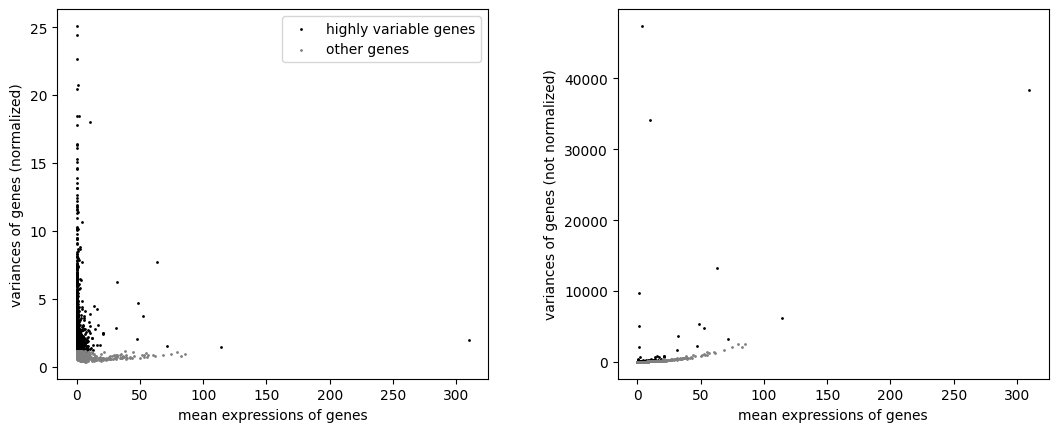

In [8]:
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

# Dimensionality reduction: PCA

scRNA-seq attempts to measure the mRNA transcripts of all the genes (~20,000) at single-cell level resolution resulting in a high-dimensional data. The cells represent the samples while the genes represent the features or dimensions of the data. These features/dimensions define the phenotype of each single cell. A cellular phenotype vector points to the location of a cell in a high-dimensional space whose each axis is represented by each of the measured features (genes).

Meanwhile, we know that the genes and their products inside cells form modules, a result of genes being co-regulated. The modular and co-regulatory structure of gene interaction means that a typical scRNA-seq data displays correlation structure among groups of genes. Thus, we are capturing redundant information by measuring all genes from a single cell. Put differently, there are only a few key variables (possibly latent) that are driving the underlying biological process. One consequence of this realization is that the cellular phenotype space is really a low-dimensional object embedded onto a high-dimensional space, i.e. the biological system really has few free variables but is projected onto a space of thousands of features. We call the low-dimensional object the data manifold. It refers to the true structure of the data irrespective of how it is embedded; and understanding the manifold holds the key to uncovering the underlying biology. The notion of dimensionality reduction is thus to extract those few meaningful dimensions that are reflective of the true underlying biological process.

Futhermore, performing dimensionality reduction on the data reduces the number of dimensions, so it has an added advantage of speeding-up computation (especially when dealing with millions of cells).

PCA (Principal Component Analysis) is one of the most popular dimensionality reduction algorithms. In short, PCA takes in a high-dimensional data as input and outputs a transformed data with the same number of samples (cells) but with reduced number of dimensions such that the recovered dimensions represent directions of highest variances in the original data.

In [9]:
sc.tl.pca(adata, n_comps=100, use_highly_variable=True)

A brief explanation of the code above:

We provide adata as an input to the method. As with any other Scanpy method, since we do not specify anything else, the PCA is run on adata.X. Now, we recall that adata.X holds the log-normalized data (or the z-scored normalized data if you succesfully executed sc.pp.scale function above and did not set adata.X to be log-norm data). Remember: it is crucial that you run PCA on your normalized data (which for the sake of this example notebook is median library size normalization + log transformation).

Second, we specify n_comps = 100, indicating that we are interested only in the top 100 components.

Third, we specify use_highly_variable = True which ensures that PCA is computed only on the highly variable genes.

In [10]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_data'

To choose the optimal number of principal components, we can visualize the cumulative variance explained:

Text(0, 0.5, '% Variance Explained')

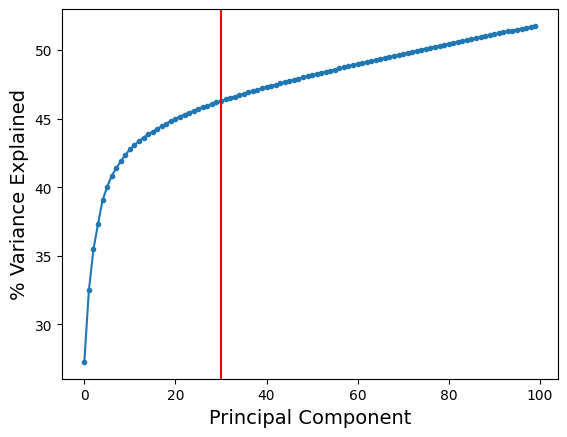

In [11]:
plt.plot(range(len(adata.uns['pca']['variance_ratio'])), np.cumsum(adata.uns['pca']['variance_ratio']) * 100, '.-')
plt.axvline(30, color = 'r')
plt.xlabel('Principal Component', fontsize = 14)
plt.ylabel('% Variance Explained', fontsize = 14)

As we can see, the increase in variance explained is minimal after about 30 components (as indicated by the red line). So, it is reasonable to perform downstream analysis using 30 principal components.

One can argue that it might be sufficient to choose 20 or 25 principal components based on our argument above. But we recommend to be slightly conservative and err on the side of choosing slightly more principal components. However, since there is no absolute way to establish the right number of components, we strongly recommend that you consider evaluating consistency of downstream results (clustering or trajectories) by altering the number of principal components slightly around the chosen value. In the above example, you can see how downstream results change if you alter the number of principal components between 20 to 50.

For now, we will proceed with 30 components.

In [12]:
adata.obsm['X_pca'] = adata.obsm['X_pca'][:, 0:30]

In [13]:
adata.obsm['X_pca'].shape

(11984, 30)

Similarly, we want to update the loadings `adata.uns['loadings']` and `adata.varm['PCs']` to reflect only the top 30 principal components.

In [14]:
adata.varm['PCs'] = adata.varm['PCs'][:, 0:30]

## Note: Genes-Loadings connection

As we discussed above, we can use the loadings to identify the most influential genes onto each of the PCA.

We will sort the gene names by their loadings for the top 30 PCA. First let's create a pandas dataframe of PCA loadings and the corresponding highly variable genes.

In [15]:
df_loadings = pd.DataFrame(adata.varm['PCs'], 
                           index = adata.var.index, 
                           columns = ['PC-' + str(j) for j in range(30)])

In [16]:
df_loadings.head()

PC-0  PC-1  PC-2  PC-3  PC-4  PC-5  PC-6  PC-7  PC-8  PC-9  ...  \
AL627309.1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
AL627309.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
LINC01409    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
LINC01128    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
LINC00115    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

            PC-20  PC-21  PC-22  PC-23  PC-24  PC-25  PC-26  PC-27  PC-28  \
AL627309.1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
AL627309.5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
LINC01409     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
LINC01128     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
LINC00115     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            PC-29  
AL627309.1    0.0  
AL627309.5    0.0  
LINC01409     0.0  
LINC01128     0.0  
LINC00115     0.0  

[5 rows x 30 columns]

Since we ran PCA on HVG, let's make sure that we look at the loadings specific to HVG only. For this we will only consider genes in the HVG.

In [17]:
df_loadings_hvg = df_loadings.loc[adata.var_names[adata.var['highly_variable']]]

In [18]:
df_loadings_hvg

PC-0      PC-1      PC-2      PC-3      PC-4      PC-5  \
HES4       0.003460  0.001495  0.004655  0.024923  0.027061 -0.005100   
ISG15      0.025548 -0.010428  0.018005  0.043884  0.034518  0.016557   
TNFRSF18  -0.001926 -0.002227  0.010640 -0.000202 -0.001739  0.009756   
TNFRSF4   -0.002326 -0.003271  0.003786  0.001185 -0.000252  0.025617   
AJAP1     -0.000105  0.000798  0.000185 -0.000454  0.000649  0.000810   
...             ...       ...       ...       ...       ...       ...   
F8         0.000030 -0.000340  0.001149 -0.000932 -0.000125  0.001024   
CLIC2      0.001227  0.001176  0.000546  0.003140  0.005460  0.001243   
TMLHE-AS1 -0.001851  0.004959  0.001356 -0.005623  0.005996 -0.003384   
TMLHE      0.002869  0.007232  0.000418 -0.006841  0.017279 -0.002727   
MT-CO1     0.013434  0.005554  0.021370  0.025839 -0.029545 -0.017136   

               PC-6      PC-7      PC-8      PC-9  ...     PC-20     PC-21  \
HES4      -0.010910  0.031612 -0.002016 -0.029858  ... -0.005577 -0.001592   
ISG15     -0.046805 -0.131785  0.082209 -0.043594  ... -0.012146  0.001861   
TNFRSF18  -0.000958  0.005888  0.001802 -0.005096  ...  0.004989  0.007858   
TNFRSF4   -0.003469  0.006719  0.003083 -0.001872  ...  0.004027  0.014150   
AJAP1      0.009929 -0.001191  0.005828 -0.004675  ...  0.000171 -0.000859   
...             ...       ...       ...       ...  ...       ...       ...   
F8        -0.000448 -0.000670 -0.001311  0.000317  ... -0.000260 -0.000183   
CLIC2      0.009093 -0.000866 -0.010418  0.008147  ... -0.004586 -0.001762   
TMLHE-AS1 -0.004824  0.003624 -0.004341 -0.001396  ... -0.006034  0.002125   
TMLHE     -0.005216  0.004149 -0.010962 -0.000693  ... -0.001637 -0.008905   
MT-CO1    -0.004244  0.030658  0.036907  0.045738  ... -0.030893 -0.021095   

              PC-22     PC-23     PC-24     PC-25     PC-26     PC-27  \
HES4       0.001108 -0.007328 -0.001087  0.002984  0.005398 -0.015227   
ISG15     -0.000153 -0.076601  0.041966 -0.040002 -0.015070  0.051024   
TNFRSF18  -0.004543 -0.000308  0.007913  0.000881 -0.000160 -0.003423   
TNFRSF4   -0.008061  0.000240  0.007270 -0.004165 -0.004229 -0.004143   
AJAP1     -0.002204 -0.001190  0.000733  0.001044  0.000836  0.000032   
...             ...       ...       ...       ...       ...       ...   
F8         0.003370  0.000279  0.002084  0.000202 -0.000125 -0.002253   
CLIC2      0.004911 -0.001560 -0.002087 -0.000505 -0.003225 -0.000520   
TMLHE-AS1 -0.000821 -0.007054 -0.006851 -0.009666 -0.002975  0.000777   
TMLHE     -0.002481 -0.010080 -0.007547 -0.013333 -0.007706  0.013950   
MT-CO1    -0.032621 -0.007703  0.029223  0.044550  0.025316 -0.023050   

              PC-28     PC-29  
HES4      -0.003382 -0.006898  
ISG15     -0.027368 -0.034242  
TNFRSF18  -0.001428 -0.003782  
TNFRSF4   -0.001100 -0.005622  
AJAP1     -0.001007 -0.000782  
...             ...       ...  
F8        -0.001827  0.000195  
CLIC2     -0.003054  0.001727  
TMLHE-AS1  0.000721 -0.001407  
TMLHE      0.002581 -0.007681  
MT-CO1    -0.000511  0.020105  

[4000 rows x 30 columns]

We can sort the dataframe constructed above for any particular PCA.

A note on the sign of the loadings: Since both the positive and negative extreme values of each principal components are treated equally in data interpretion, it stands to reason that we want to look at the absolute value of the loadings.

In [19]:
np.abs(df_loadings_hvg).sort_values(by = 'PC-0', ascending = False)['PC-0']

LYZ         1.400950e-01
S100A9      1.391812e-01
S100A8      1.175034e-01
CTSS        1.035663e-01
VCAN        9.564024e-02
                ...     
DCLK2       1.556435e-06
SCG5        5.045683e-07
NRG3        3.220663e-07
GPR173      2.408021e-07
TMEM132B    1.863688e-07
Name: PC-0, Length: 4000, dtype: float64

As we can see, the first principal component is dominated by LYZ, S100A9, S100A8, CTSS etc. which are certain myeloid markers. This indicates that the most variance in the data is driven by myeloid specific genes.

Whether these genes are relevant/important for your study is something you will have to decide. Why might we want to study the loadings? The reason is sometimes we notice that some of the principal components are driven by the expression of mitochondrial genes or ribosomal genes. And depending on the question you are trying to answer it might be of interest to remove the effect of such genes. This way you can identify if the principal components are being influenced by these nuisance genes and if you need to adjust your set of hvg (for example remove mitochondrial genes or ribosomal genes from the list of hvg or add some new set of context specific genes) for downstream computation.

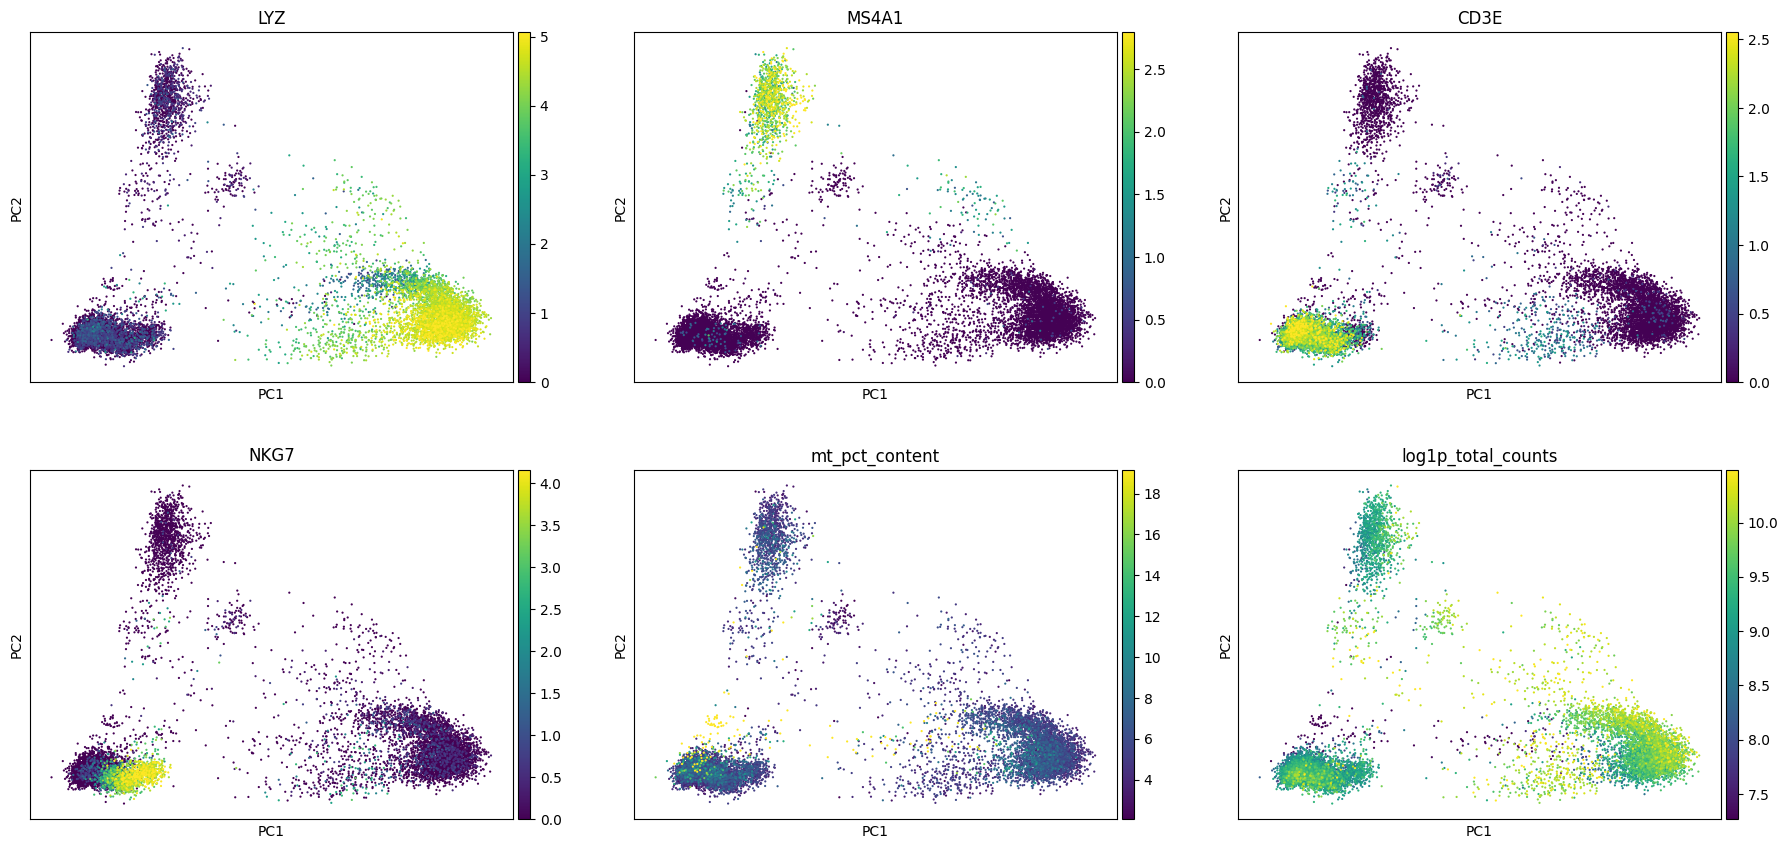

In [21]:
sc.pl.pca(adata, color = ['LYZ', 'MS4A1', 'CD3E', 'NKG7', 'mt_pct_content', 'log1p_total_counts'], 
          ncols = 3, vmin = 'p1', vmax = 'p99')

# Nearest neighbor graph

As we have already mentioned, cellular phenotype space is modeled as a low-dimensional object (called the data manifold) embedded in a high-dimensional space. The expression pattern of genes define the manifold structure. So cells with similar expression profiles are close to each other on the manifold. In other words, the local neighborhood of each cell on the manifold consists of similar cells. This is an important property that must be satisified by any method to accurately capture the structure of the manifold (such as for visualization). In addition, the manifold only depends on the connectivity of the data points - defined via pairwise distances - and not on how the points are arranged in space. Therefore, quantifying cell-cell distance is important to study the manifold structure of the data.

In the context of single-cell biology, the data manifold is a characterization of the available space of phenotypes for any cell in that context. Exploring the manifold is therefore equivalent to exploring the possible cellular states, and any defect/perturbation in the molecular processes should reflect as a change in the phenotype landscape. This deviation from normal expression would reflect as a change in characteristics of the data manifold, such as volume or variance or regions of occupancy, analyzing which can help us understand the cause and consequences of the changes.
  
Understanding the manifold of a high-dimensional data is a problem that pervades several disciplines. As a result, many methods have been proposed to tackle this problem. It is easier to obtain the structure if the underlying manifold is linear - that is, the observed features can be written as a linear combination of the latent variables. Linear methods such as Principal Component Analysis (PCA), discussed above, have been successfully applied in such cases. However, in scRNA-seq data, genes often display non-linear association. The non-linearity is a result of the measured genes themselves being a non-linear combination of the latent variables driving the process, which is in turn a result of the cascades of non-linear interactions, checkpoints and feedback mechanisms a cell has in place. Thus, characterization of the manifold requires us to involve methods that take into account the non-linearity present in single-cell data.

To tackle the issue of non-linearity, we aim to characterize the data manifold by first analyzing data locally around every cell, and then combining them. We assume that around each cell, the local neighborhood is roughly linear (or Euclidean), so we will apply linear methods locally and aggregate to get the total picture of the manifold. This notion of analyzing data to characterize the underlying manifold has proven beneficial in single-cell data analysis. From a mathematical point of view, graphs are the perfect tools designed for this. 

A graph is defined as a set `G = {V,E,W}` consisting of a set of nodes or vertices `V`, a set of edges `E` connecting all or some of the vertices and weights `W` assigned to each of the edges. In the graph representation of single-cell data, each cell is a vertex or node in the graph, two cells are connected if they are similar to each other and the weight between them is the quantification of similarity between them. The similarity between two cells can be obtained by measuring the distance between them. The choice of distance metric, however, is context dependent but due to its ease and useful properties, Euclidean distance seems to be the preferred choice in the single-cell field. The manifold is congruent to a Euclidean space locally around any given point so, it is sensible to use Euclidean distances to compute similarity in the small neighborhood. In particular, for every cell we first find the `k` nearest neighbors (typically `k` is set to < 1% of the total number of cells profiled, a typical choice is `k = 30`) based on Euclidean distance, which will comprise the local neighborhood. Each cell is thus connected to its `k` nearest neighbors by an edge and the constructed graph (called the _k-nearest neighbor graph_) approximates the underlying manifold. The phenotypic distance between any two cells on such graph is then defined by _geodesics_ along the graph, which more accurately captures biological differences between cells.

Majority of the visualization, clustering and trajectory inference tools build on top of the above constructed graph. While the thus constructed graph may need to be further adjusted to account for the inherent noise in the data it forms the backbone of most of the tools we will discuss henceforth. We use Scanpy's inbuilt method to construct graph:

In [22]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/pyt

An explanation of the code above:

1. We ask for `k = 30` nearest neighbors. This is a typical choice in data analysis but you can compute graphs for multiple values of `k` and study how the downstream result changes (in fact we encourage you to do this to study how your downstream biological interpretations (such as visuals, clustering etc.) alter with slight changes in `k`. For example for this case, you may want to study values of `k` between 20-40.)

2. We set `use_rep = 'X_pca'` because we want to compute the k nearest neighbor graph on the above computed PCA. PCA has been observed to be good in capturing global aspects of the data, but to study finer structures of the biological manifold, we recommend building graph on top of the PCA. Furthermore, considering only top principal components has the added advantage of removing noise from the data represented by the lower principal components.

3. We set `metric = 'euclidean'` but you are encouraged to explore other metrics such as `'cosine'` or `'correlation'`. The single-cell field still has not agreed upon the best choice of metric or comprehensively identified situations where certain metrics might be better suited than others.

4. We set `key_added = 'neighbors_30'` to store our results with the name 'neighbors_30'. This can be a handy tool should you want to compute multiple graphs, as you can simply store multiple results with different names. For more details on this, please see Scanpy API on nearest neighbors. 

In [23]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [24]:
adata.obsp['neighbors_30_distances']

<11984x11984 sparse matrix of type '<class 'numpy.float64'>'
	with 347536 stored elements in Compressed Sparse Row format>

The distances (which measure dissimilarity between cells) are represented as a sparse matrix for 11984 cells as shown above. Scanpy also converts the distances into similarities and outputs them as connectivities.

In [25]:
adata.obsp['neighbors_30_connectivities']

<11984x11984 sparse matrix of type '<class 'numpy.float32'>'
	with 500544 stored elements in Compressed Sparse Row format>

Note the number of non-zero entries in the matrices are different because the connectivities is a symmetric matrix while distances is not.

All major downstream analysis methods utilize thus constructed graph to visualize, cluster or infer trajectories from the data. We begin by exploring the visualization methods and will run UMAP and Force Directed Layout. As such, if you want to change the properties of the neighbor graph (e.g. for a specific visualization or clustering), you would need to re-run the neighbors command.

# Data Visualization

## UMAP

Uniform Manifold Approximation and Projection (UMAP) has been applied to visualize and analyze sc-RNAseq data. In summary, UMAP uses the graph we built above and tries to arrange data points on a low-dimensional space (typically in 2D) such that the cross-entropy of the high-dimensional graph weights and low-dimensional graph weights is minimized. The author of UMAP has written a beautiful exposition on how UMAP works, which can be found here: https://bit.ly/2qGhBkk.

Note: UMAP preserves high-dimensional distances on the projected space, which suggests that one can do further analysis on UMAP features. However, this should be done with care and we strongly recommend against it. Specifically because we have the tools needed to perform efficient analytic computations (such as clustering, trajectory detection etc.) in the high dimensions itself; thereby precluding the need to do computations on UMAP. For some FAQs on UMAP, please see this page: https://bit.ly/2NfgAxY.

In [26]:
sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)

Because we saved our k-nearest neighbor results as `neighbors_30`, we need to specify it as above. We recommend setting min_dist = 0.1 because that was the original default proposed in UMAP algorithm and seems to produce more visually appealing plots. We can do this because the sole purpose of UMAP is to aid in visualization. No quantitative information should be extracted from UMAP (e.g. definite distance/proximity between cells/clusters).

In [27]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [28]:
adata.obsm['X_umap']

array([[ 1.6250963,  5.5733585],
       [-4.103601 ,  6.767667 ],
       [-1.0423499,  6.822509 ],
       ...,
       [10.327127 , 10.977615 ],
       [15.360161 ,  2.9707499],
       [ 9.139833 , -1.1203988]], dtype=float32)

In [29]:
adata.obsm['X_umap'].shape

(11984, 2)

Now we can visualize the results:

/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


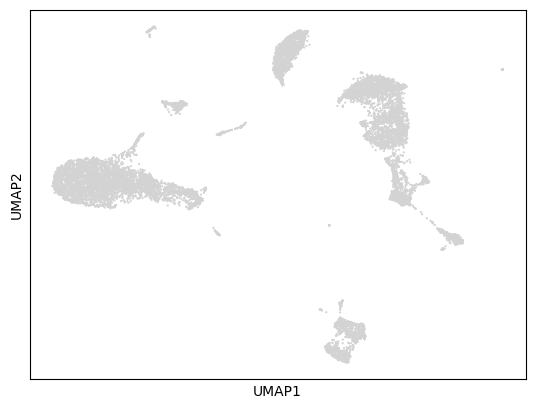

In [30]:
sc.pl.umap(adata)

# Visualization examples

In [31]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

## Color by metadata

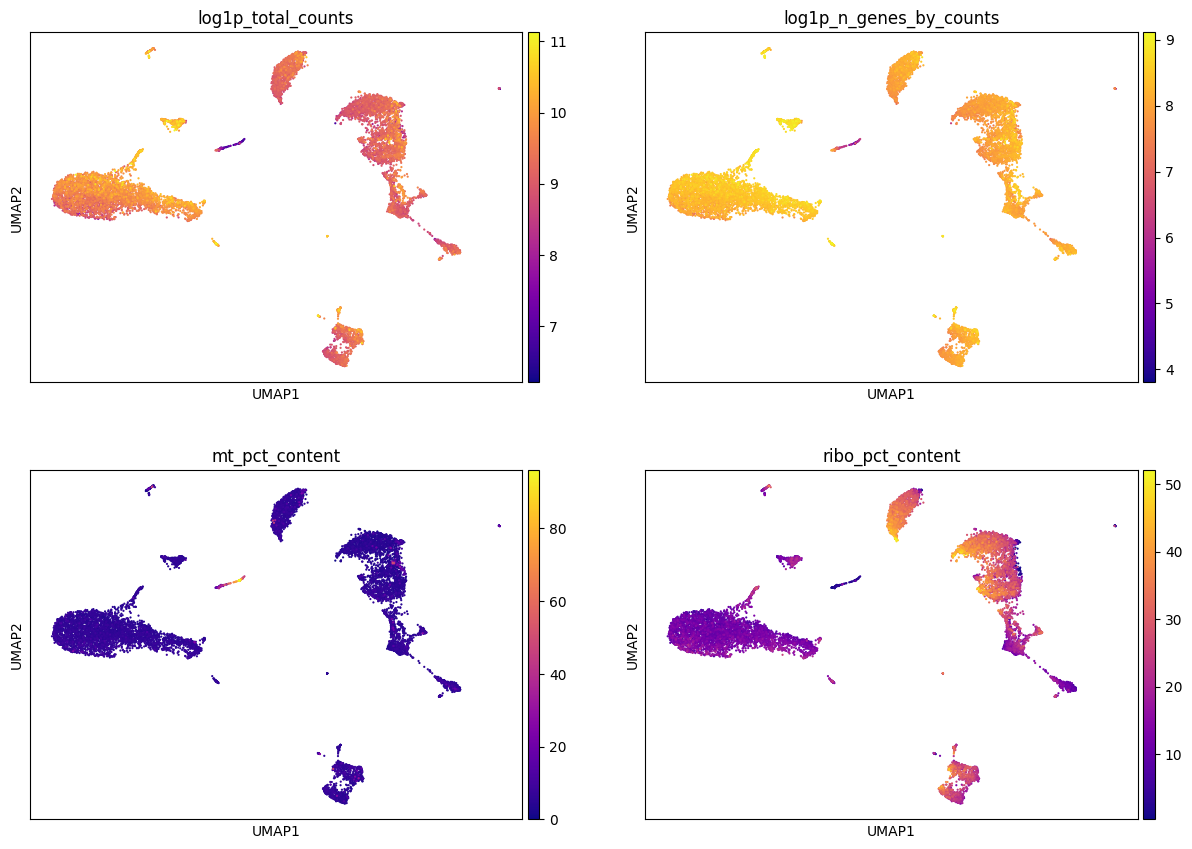

In [32]:
sc.pl.umap(adata, color = ['log1p_total_counts', 'log1p_n_genes_by_counts', 'mt_pct_content', 'ribo_pct_content'], 
           ncols = 2, cmap = 'plasma', use_raw=False)

## Color by gene expression

We can use the computed UMAP projections to visualize gene expression. This can help us perform some basic sanity checks (if known genes are expressed appropriately), develop hypotheses and aid in cell type annotation (which we will look at next in clustering segment).

For now, since we are looking at PBMCs, we will do some sanity checks using established set of genes used to identify various PBMC cell types (list taken from: https://satijalab.org/seurat/archive/v3.0/pbmc3k_tutorial.html)

['PTPRC', 'CD3E', 'CD8A', 'CD4', 'IL7R', 'MS4A1', 'CD19', 'LYZ', 'FCGR3A', 'NKG7', 'CST3', 'PPBP']

We can make these visuals using Scanpy's inbuilt UMAP plot function. Important note: By default, Scanpy's inbuilt function may rely on `adata.raw` to extract gene expression if you have `adata.raw` saved. So please be careful that you set `use_raw = False` if you have adata.raw set to store the original raw counts as you may rather want to visualize log-normalized counts which is stored in `adata.X`.

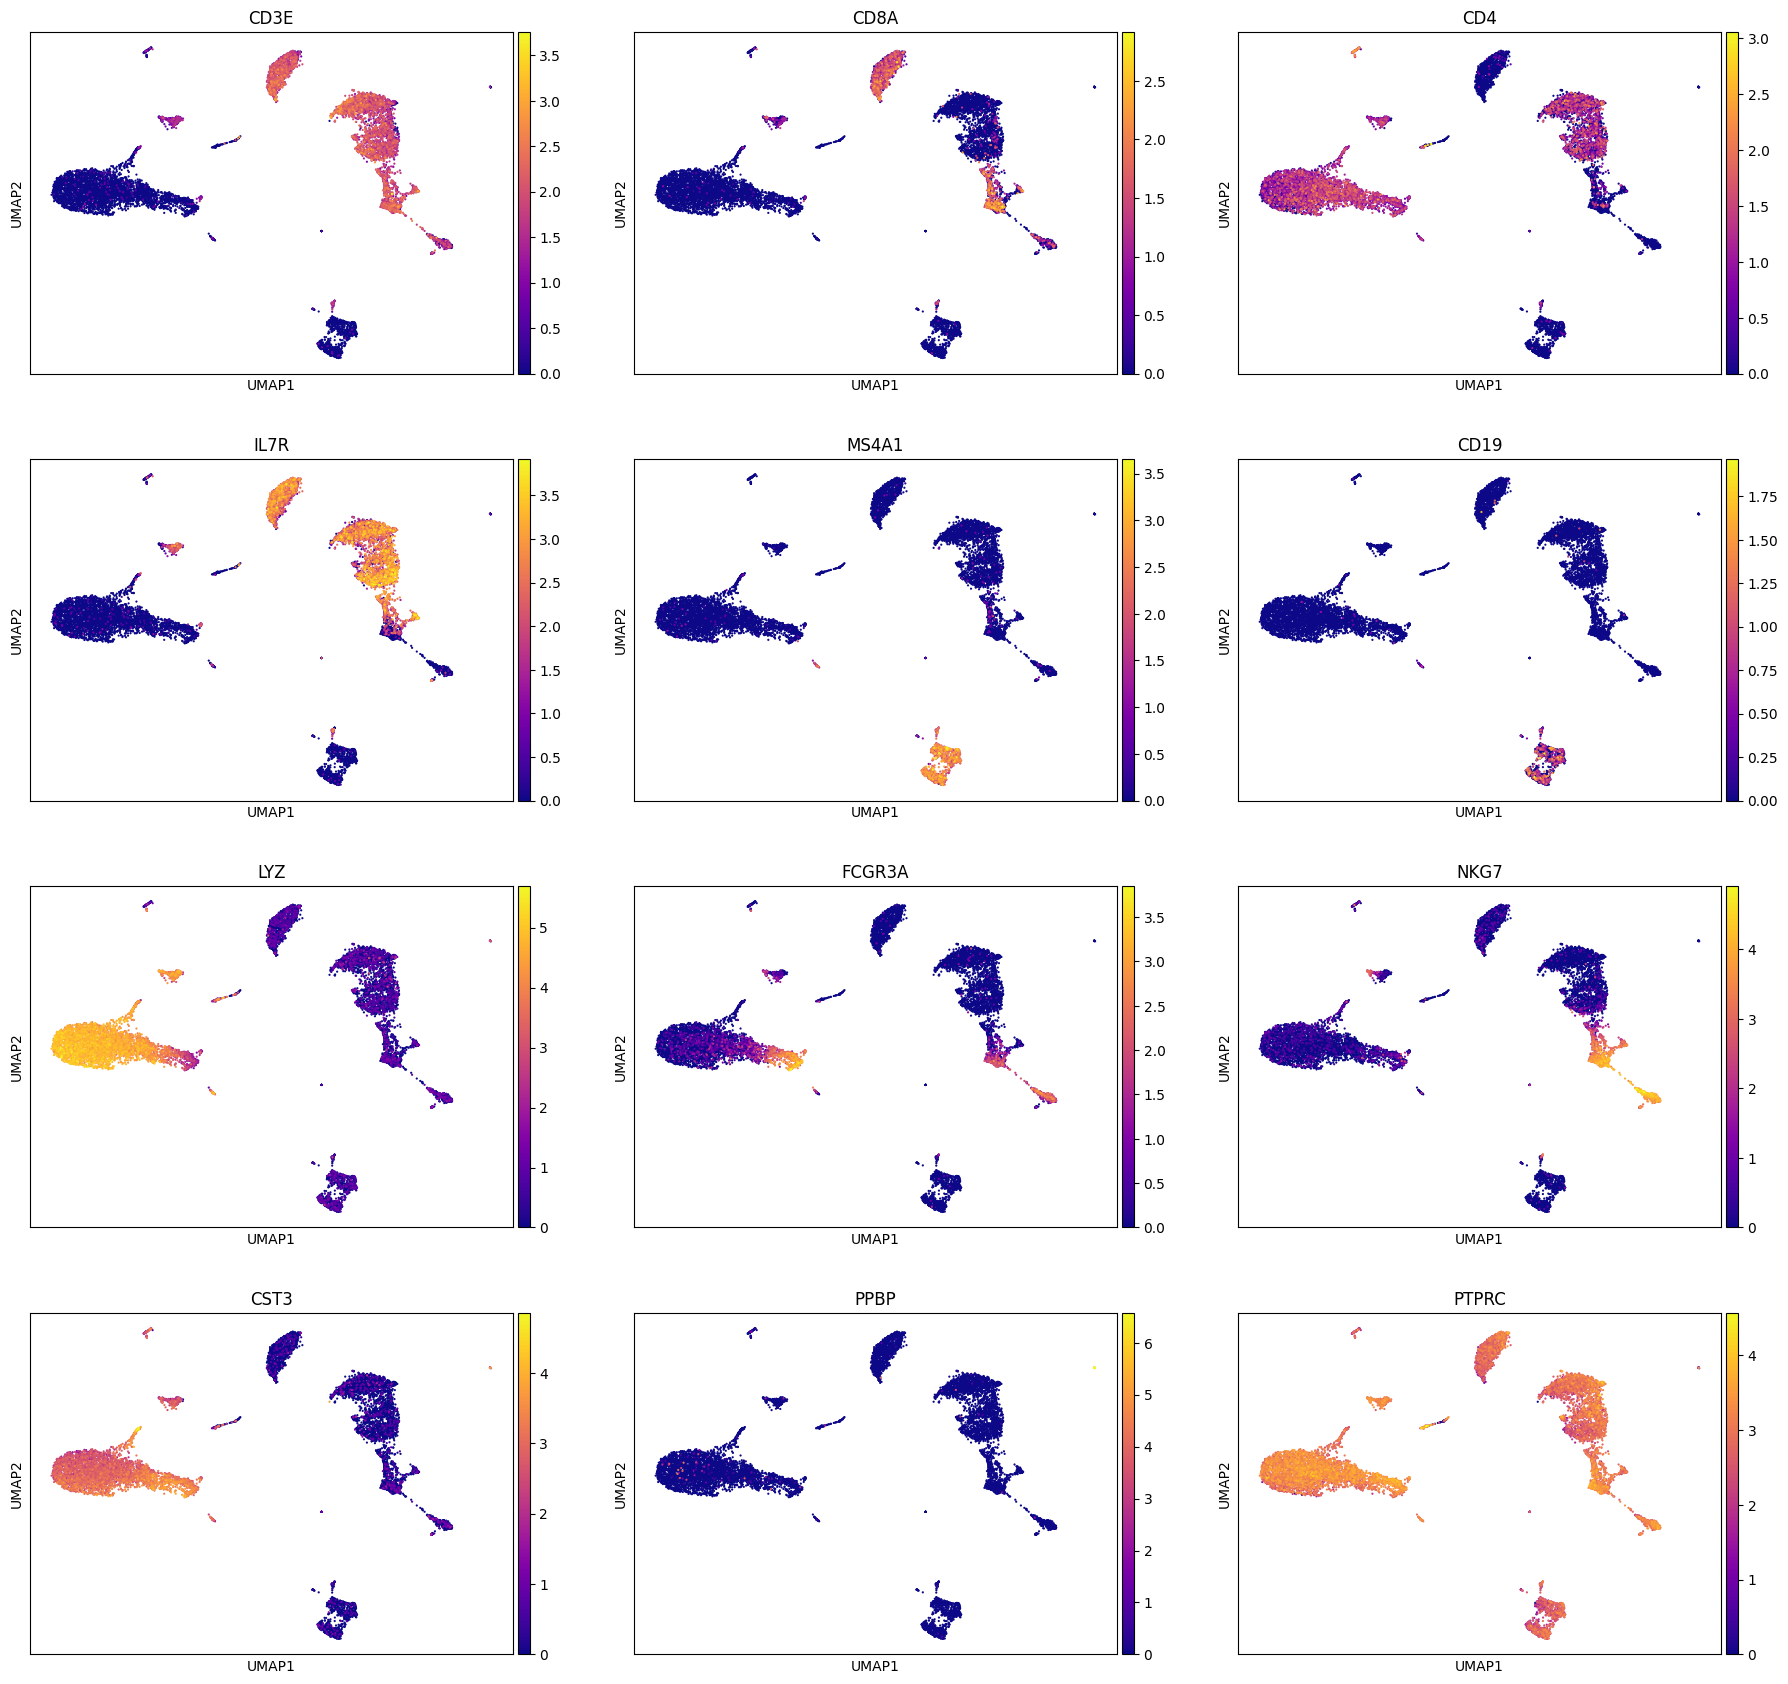

In [33]:
genes = ['CD3E', 'CD8A', 'CD4', 'IL7R', 'MS4A1', 'CD19', 'LYZ', 'FCGR3A', 'NKG7', 'CST3', 'PPBP', 'PTPRC']
sc.pl.umap(adata, color = genes, cmap = 'plasma', ncols = 3, use_raw=False)

A note: Sometimes it helps to trim the expression levels of genes to certain percentiles to avoid visualization being biased by a few super-high or super-low values. For this we can utilizie vmin and vmax parameter during plotting as shown below. We will set vmin = 1 percentile of gene expression and vmax = 99 percentile of gene expression, which means min gene expression is going to be 1 percentile of the original expression and analogously for max expression.

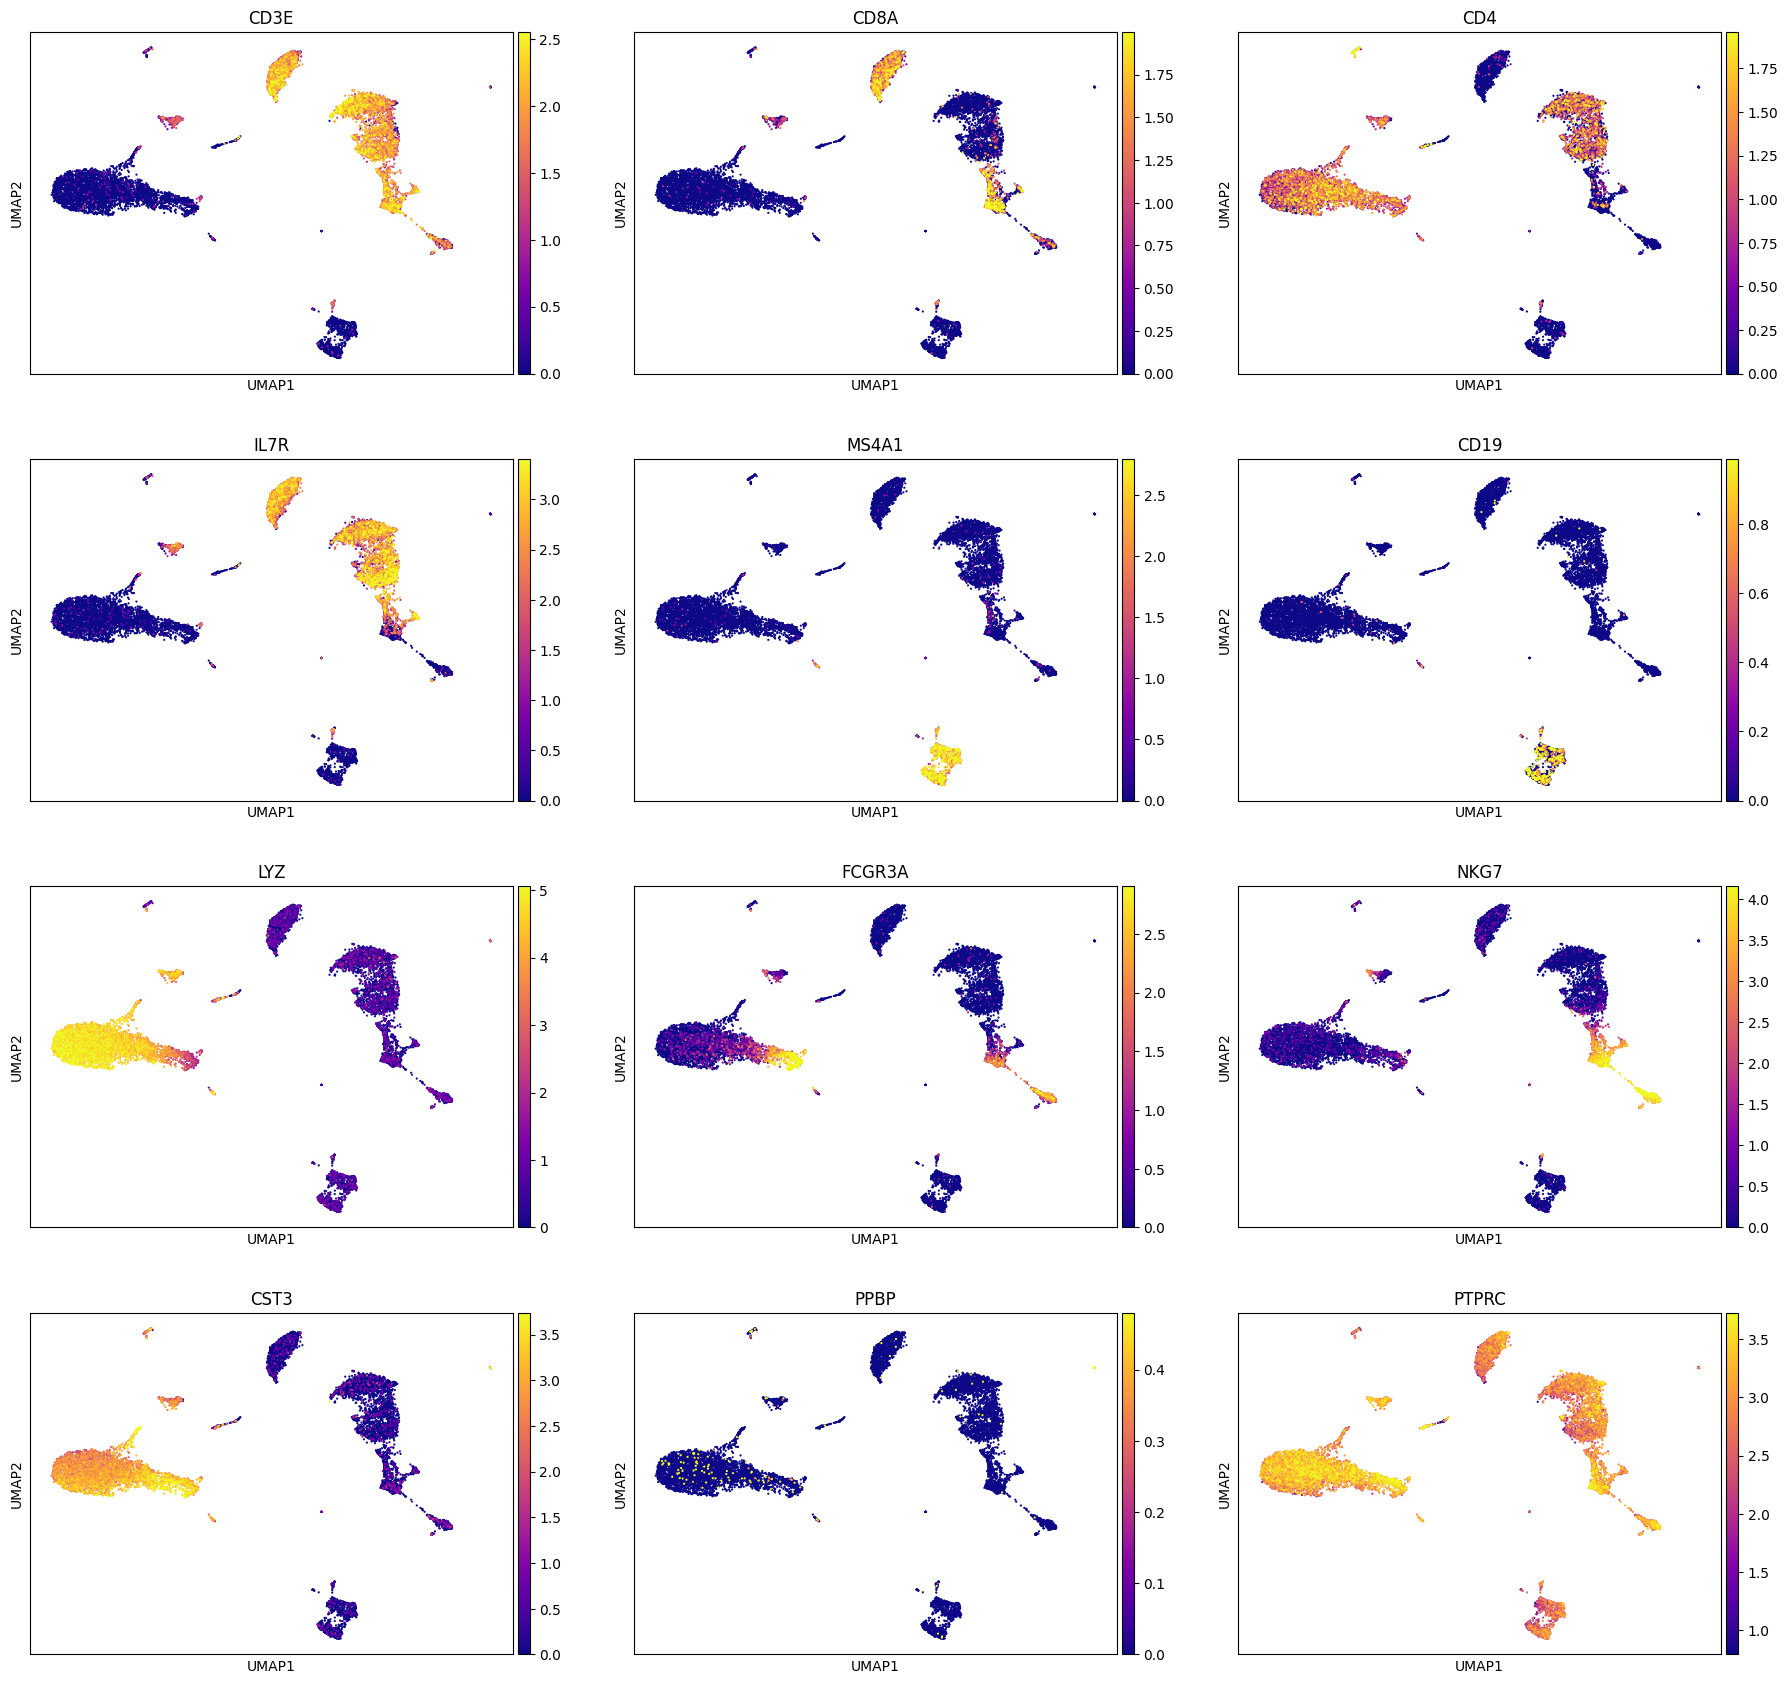

In [34]:
genes = ['CD3E', 'CD8A', 'CD4', 'IL7R', 'MS4A1', 'CD19', 'LYZ', 'FCGR3A', 'NKG7', 'CST3', 'PPBP', 'PTPRC']
sc.pl.umap(adata, color = genes, cmap = 'plasma', ncols = 3, use_raw=False, vmin = 'p1', vmax = 'p99')

### Alternate code (more manual)

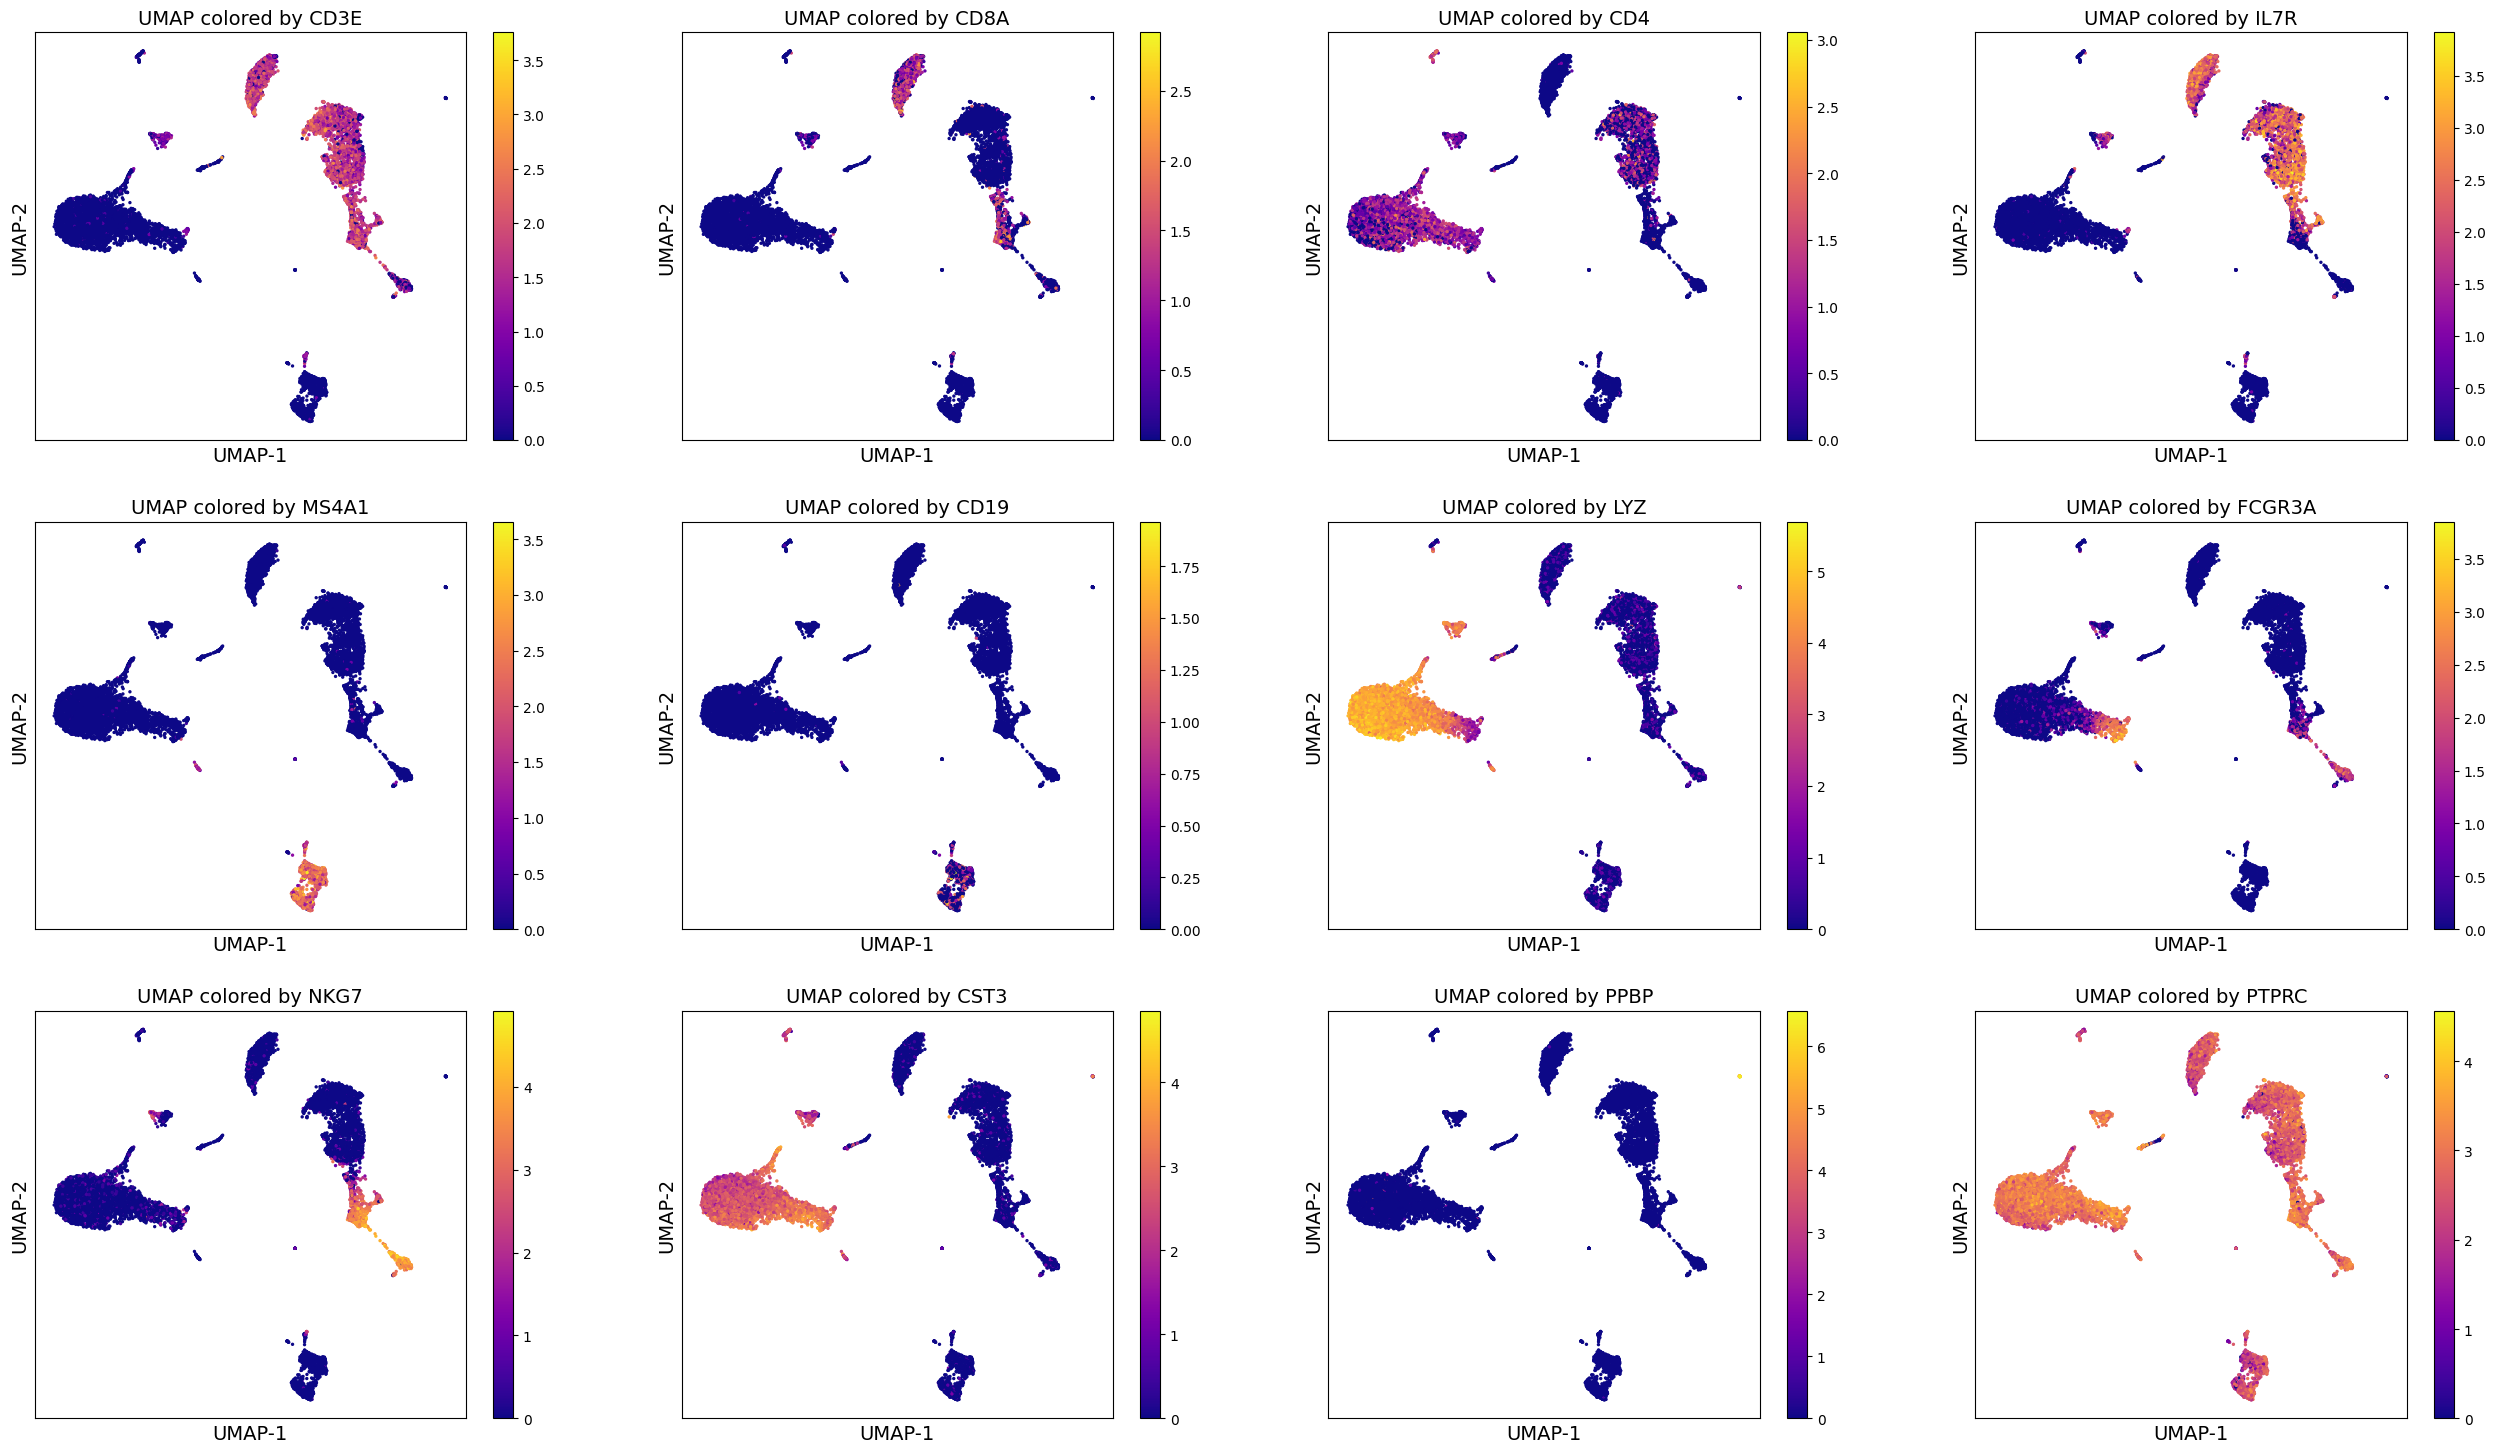

In [35]:
genes = ['CD3E', 'CD8A', 'CD4', 'IL7R', 'MS4A1', 'CD19', 'LYZ', 'FCGR3A', 'NKG7', 'CST3', 'PPBP', 'PTPRC']

fig_nrow = 3
fig_ncol = 4

fig = plt.figure(figsize = (8*fig_ncol, 6*fig_nrow))
count = 0
for gene_name in genes:
    ax = fig.add_subplot(fig_nrow, fig_ncol, count + 1)
    col_gene = adata.X.toarray()[:, adata.var_names.get_loc(gene_name)]
    im1 = ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s = 2, c = col_gene, 
                    cmap = 'plasma')
    ax.set_xlabel('UMAP-1', fontsize = 14)
    ax.set_ylabel('UMAP-2', fontsize = 14)
    ax.set_title('UMAP colored by ' + gene_name, fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(im1)
    count = count + 1
    
# To save, please uncomment the following line of code:
# fig.savefig(output_directory, 'UMAP_colored_by_genes.png', dpi = 150, bbox_inches = 'tight')

Such visualizations can help perform data analysis better. You may already be able to draw many hypotheses and make assessment of the data using such visualizations.

Similarly, alternate code to trim the gene expression at 1 percentile and 99 percentile.

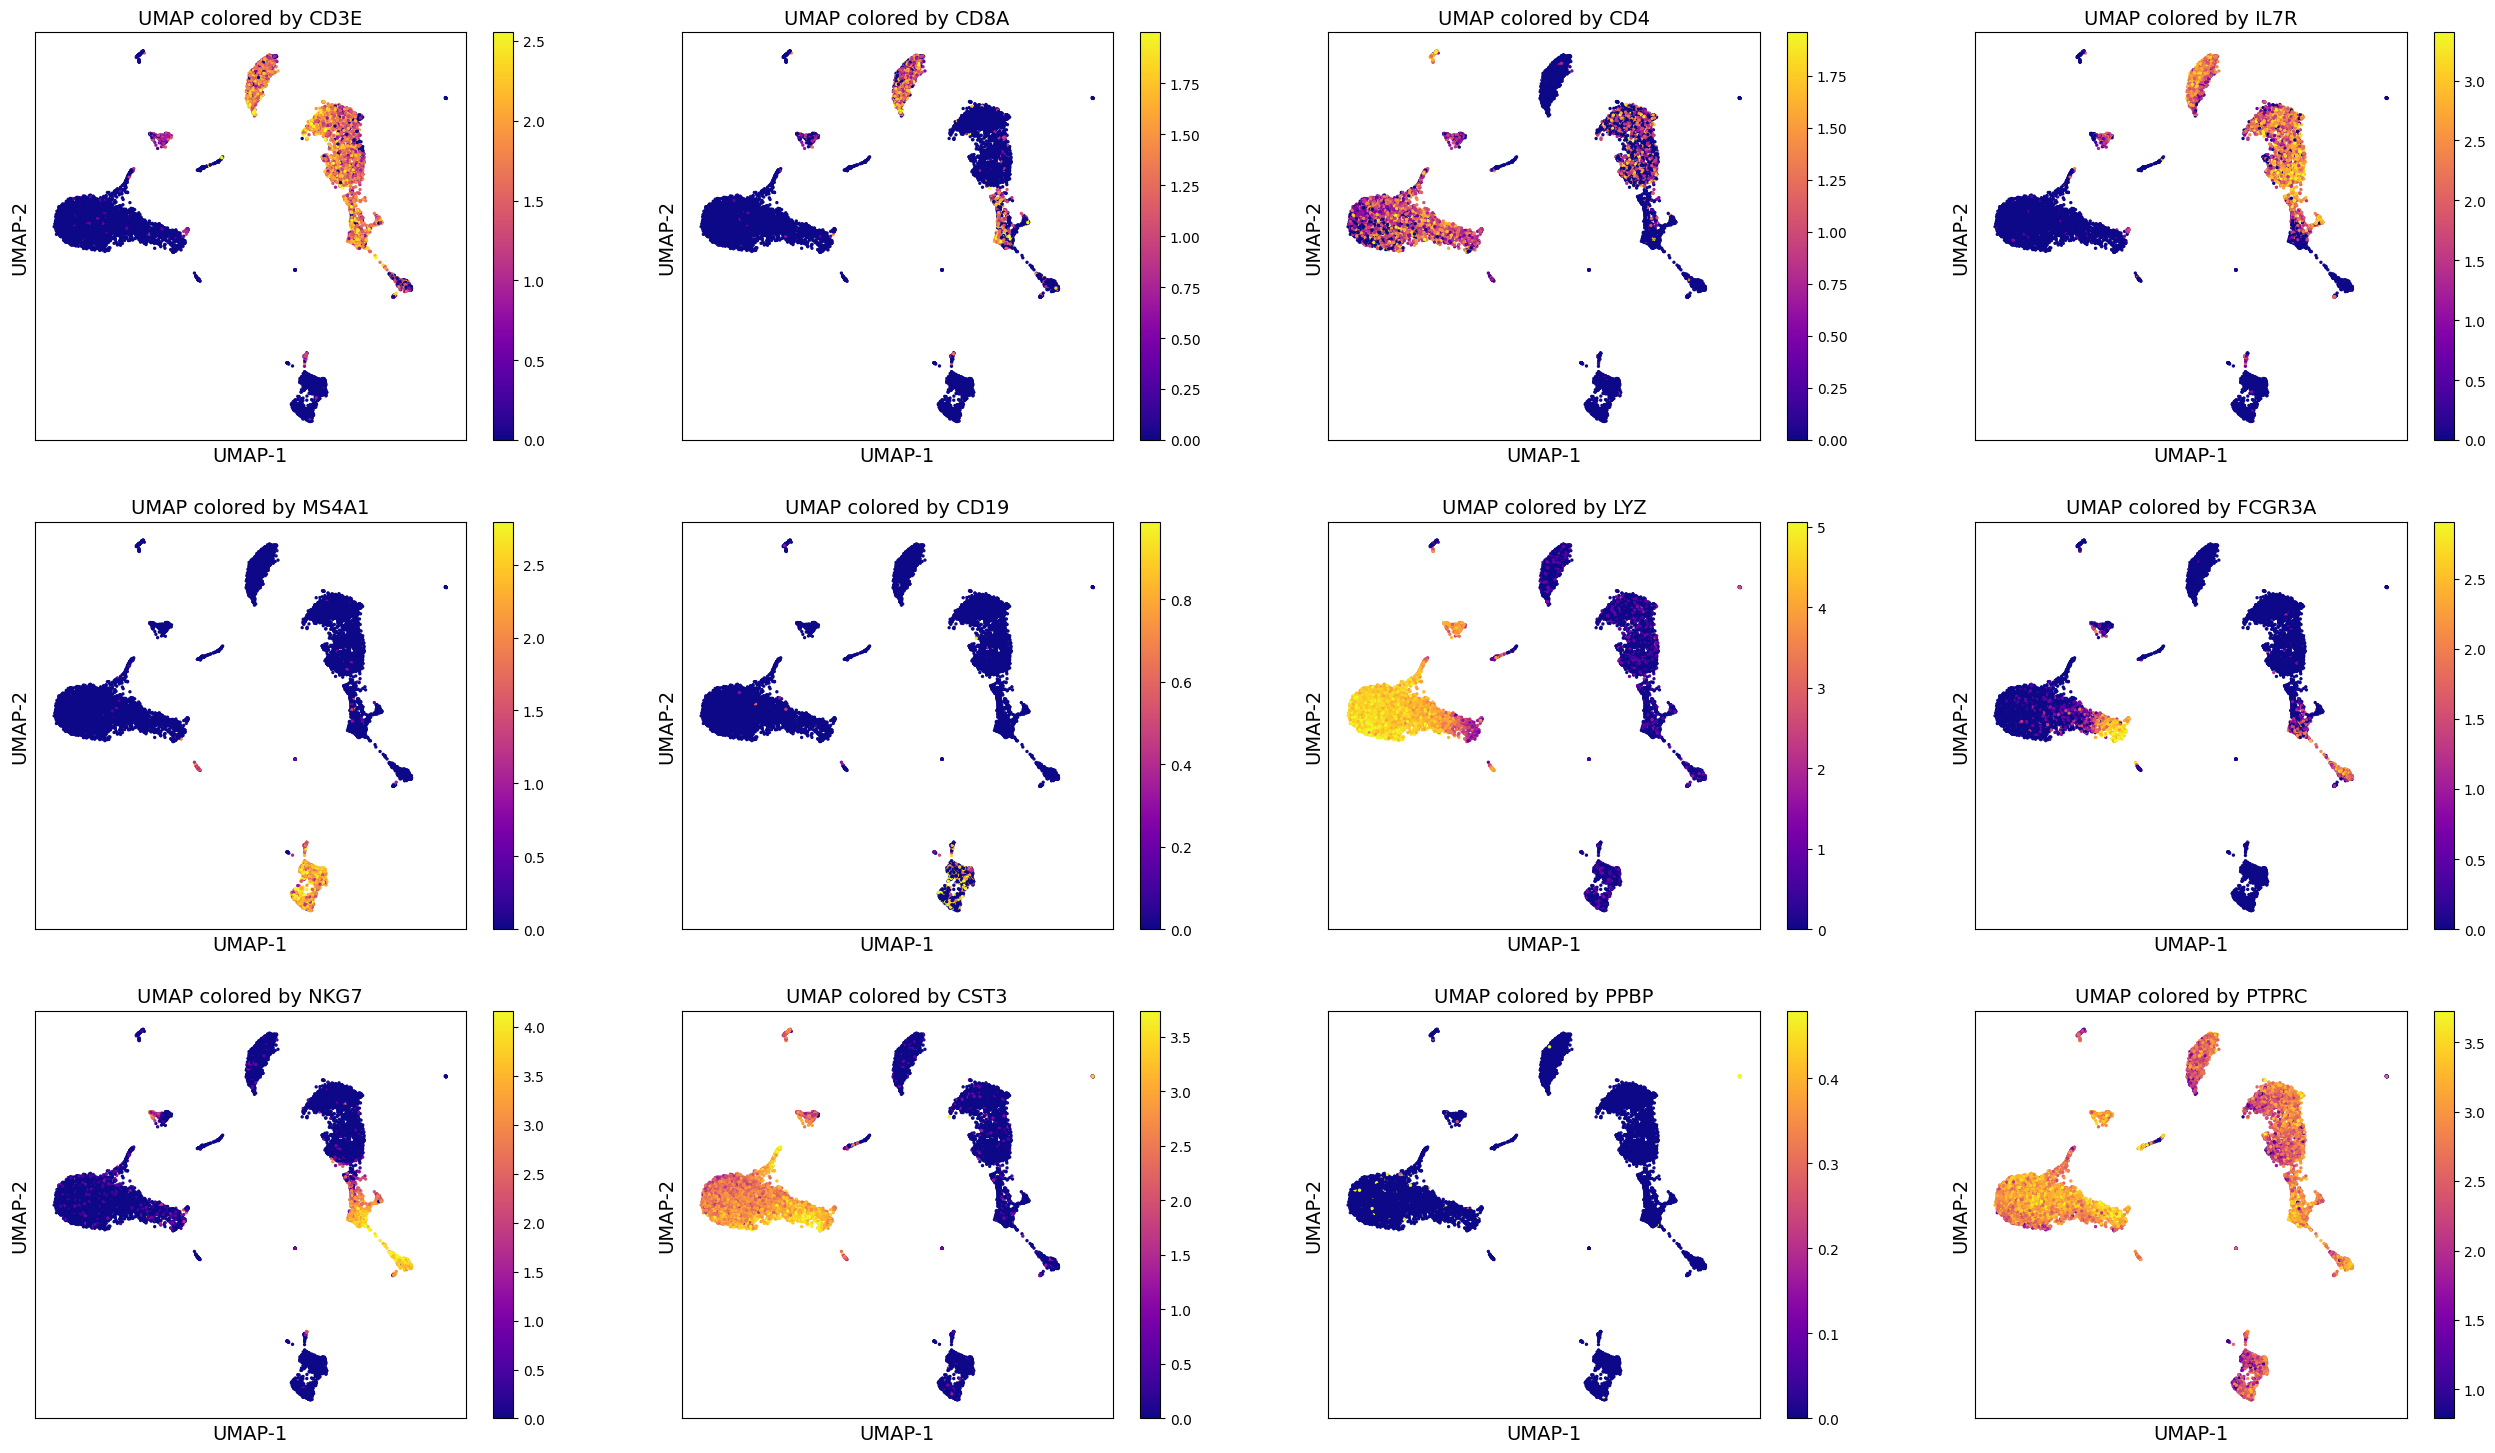

In [36]:
genes = ['CD3E', 'CD8A', 'CD4', 'IL7R', 'MS4A1', 'CD19', 'LYZ', 'FCGR3A', 'NKG7', 'CST3', 'PPBP', 'PTPRC']

fig_nrow = 3
fig_ncol = 4

fig = plt.figure(figsize = (8*fig_ncol, 6*fig_nrow))
count = 0
for gene_name in genes:
    ax = fig.add_subplot(fig_nrow, fig_ncol, count + 1)
    col_gene = adata.X.toarray()[:, adata.var_names.get_loc(gene_name)]
    im1 = ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s = 2, c = col_gene, 
                    cmap = 'plasma', vmin = np.percentile(col_gene, 1), vmax = np.percentile(col_gene, 99))
    ax.set_xlabel('UMAP-1', fontsize = 14)
    ax.set_ylabel('UMAP-2', fontsize = 14)
    ax.set_title('UMAP colored by ' + gene_name, fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(im1)
    count = count + 1
    
# To save, please uncomment the following line of code:
# fig.savefig(output_directory, 'UMAP_colored_by_genes.png', dpi = 150, bbox_inches = 'tight')

## Visualize gene signature

You can also visualize established gene signatures (from published papers or bulk signatures) onto the computed UMAP. For example, you may be familiar with Hallmark or Reactome or GO genesets. You can load any of your favorite pathway and visualize the expression using the following code as a guideline. For illustration, we have provided you with an example geneset called geneset.txt and we will use that to visualize the expression (taken from: https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_G2M_CHECKPOINT.html).

In [37]:
# load the file
geneset = pd.read_csv(input_path+'HALLMARK_G2M_CHECKPOINT.v2023.2.Hs.grp')

In [38]:
geneset

HALLMARK_G2M_CHECKPOINT
0    # https://www.gsea-msigdb.org/gsea/msigdb/huma...
1                                                 ABL1
2                                                 AMD1
3                                               ARID4A
4                                                 ATF5
..                                                 ...
196                                               UCK2
197                                               UPF1
198                                                WRN
199                                               XPO1
200                                             YTHDC1

[201 rows x 1 columns]

In [39]:
genes = geneset['HALLMARK_G2M_CHECKPOINT']
genes

0      # https://www.gsea-msigdb.org/gsea/msigdb/huma...
1                                                   ABL1
2                                                   AMD1
3                                                 ARID4A
4                                                   ATF5
                             ...                        
196                                                 UCK2
197                                                 UPF1
198                                                  WRN
199                                                 XPO1
200                                               YTHDC1
Name: HALLMARK_G2M_CHECKPOINT, Length: 201, dtype: object

In [40]:
type(genes)

pandas.core.series.Series

In [41]:
# Compute a gene signature score using Scanpy's inbuilt function
sc.tl.score_genes(adata, genes, score_name='G2_M_checkpoint', random_state=0, use_raw = False)

In [42]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet', 'G2_M_checkpoint'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

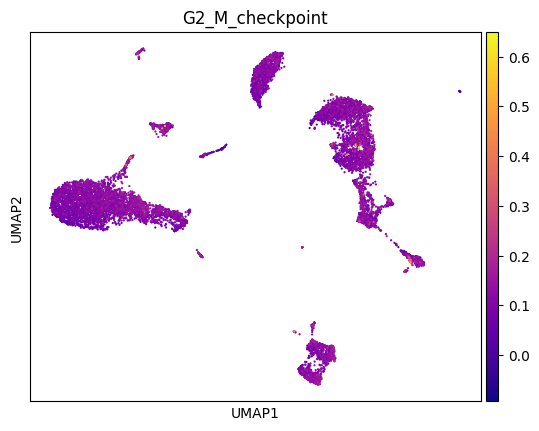

In [43]:
sc.pl.umap(adata, color = 'G2_M_checkpoint', cmap = 'plasma')

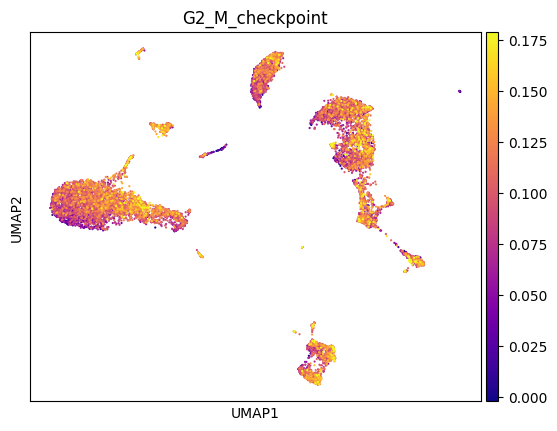

In [44]:
sc.pl.umap(adata, color = 'G2_M_checkpoint', cmap = 'plasma', vmin = 'p1', vmax = 'p99')

# Clustering

One of the primary applications of scRNA-seq has been in the identification of novel and rare cell types. In contrast to bulk measurements, which obscure the cell-cell heterogeneity, single-cell level analysis offers an unprecedented precision to classify cells into different types.

To think about it computationally: The data presents us with a bunch of objects (individual cells) that have a certain set of features (genes), and we would like to classify the objects into distinct groups or categories each consisting of similar cells. In our case, these distinct groups or categories can be biologically interpreted as cell types. Therefore, in essence the problem of identifying cell types (novel, rare or known) boils down to a problem of clustering.

Performing Modularity optimization by Leiden community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph.

Compute a `leiden` clustering with two different resolutions (`0.5` and `1.5`). Compare the clusterings in a table and visualize the clustering in an embedding.

## Leiden clustering

In [45]:
sc.tl.leiden(adata, resolution = 1.5, random_state=0, neighbors_key='neighbors_30', key_added='leiden_r1.5')
sc.tl.leiden(adata, resolution = 0.5, random_state=0, neighbors_key='neighbors_30', key_added='leiden_r0.5')

In [46]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet', 'G2_M_checkpoint', 'leiden_r1.5', 'leiden_r0.5'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [47]:
pd.crosstab(adata.obs['leiden_r0.5'], adata.obs['leiden_r1.5'])

leiden_r1.5     0     1    2    3    4    5    6    7    8    9  ...   15  \
leiden_r0.5                                                      ...        
0               0    18  993    0    0  941  617    0    0    0  ...    0   
1               5     0    0  967    1    0    0    0    0    0  ...   17   
2            1291     0    0    6    0    0    0    0    0    0  ...    7   
3               0     0    0    0  962    0    0    0    0    0  ...    2   
4               0  1028   48    0    0    0   19    1    0    0  ...    0   
5               0     0    0    0    0    0    0    0    0    0  ...  315   
6               0     0    0    0    0    0    1  613    0    0  ...    0   
7               0     0    0    0    0    0    0    0  571    0  ...    0   
8               0     0    0    0    0    0    0    0    0  494  ...    0   
9               0     0    0    0    0    0    0    0    0    0  ...    0   
10              0     0    0    0    0    0    0    0    0    0  ...    0   
11              0     0    3    0    0    0    1    0    0    0  ...    0   
12              0     0    0    0    0    0    0    0    0    0  ...    0   
13              0     0    0    0    0    0    0    0    0    0  ...    0   
14              0     0    0    0    0    0    0    0    0    0  ...    0   
15              0     0    0    0    0    0    0    0    0    0  ...    0   

leiden_r1.5   16   17   18   19   20  21  22  23  24  
leiden_r0.5                                           
0              2    0    0    1    0   0   0   0   0  
1              0    0    0    0    1   0   0   0   1  
2              0    6    0    0  103   0   1   0   0  
3              0    2    0    0    0   0   0   0   1  
4              1    0    0    0    0   0   0   0   0  
5              0    0  129    0    0   0   0   0   0  
6              0    0    0    0    0   0   0   0   0  
7              0    0    0    0    0   0  72   0   0  
8              0    0    0    0    0   0   0   0   0  
9              0    0    0    0    0   0   0  31   0  
10             0    0    0    0    0   0   0   0   0  
11           190    0    0    0    0   0   0  13   0  
12             0  148    0    0    0   0   0   0   0  
13             0    0    0  114    0   0   0   0   0  
14             0    0    0    0    0  82   0   0   0  
15             0    0    0    0    0   0   0   0  25  

[16 rows x 25 columns]

/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


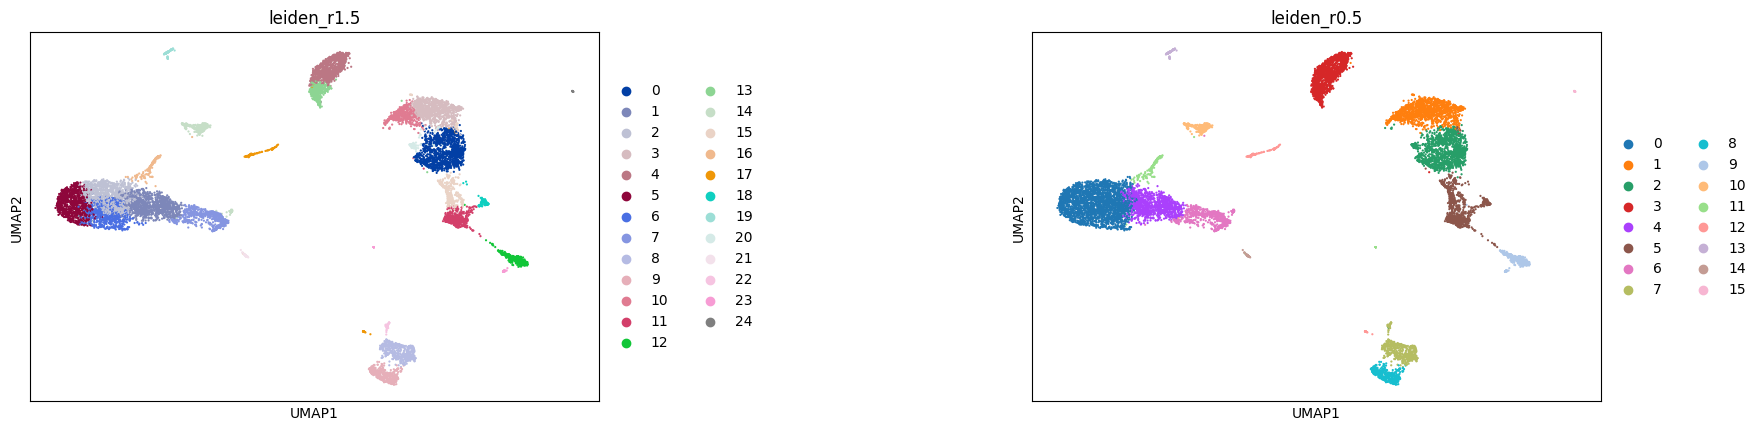

In [48]:
#Visualize the clustering 
sc.pl.umap(adata, color=['leiden_r1.5', 'leiden_r0.5'], wspace=0.6)

## Investigate % mito content, library size, number of genes expressed in each cluster

In [49]:
adata.obs.columns

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content',
       'doublet_score', 'doublet', 'G2_M_checkpoint', 'leiden_r1.5',
       'leiden_r0.5'],
      dtype='object')

In [50]:
df_temp = pd.DataFrame({'leiden': adata.obs['leiden_r1.5'], 
                        '%-Mito': adata.obs['mt_pct_content'], 
                        'library_size': adata.obs['log1p_total_counts'], 
                        'n_genes_per_cell': adata.obs['log1p_n_genes_by_counts']}, index = adata.obs.index)

In [51]:
df_temp

leiden    %-Mito  library_size  n_genes_per_cell
AAACCCAAGGCCCAAA-1      7  4.856472      9.690603          8.354910
AAACCCAAGTAATACG-1      6  4.181449      9.379154          8.239065
AAACCCAAGTCACACT-1      1  5.816601      9.581491          8.330382
AAACCCACAAAGCGTG-1      3  3.799609      8.947156          7.835975
AAACCCACAATCGAAA-1      8  5.699392      9.351058          8.158802
...                   ...       ...           ...               ...
TTTGTTGGTTGGATCT-1      4  4.210640      9.136371          7.935945
TTTGTTGGTTTCTTAC-1     11  3.039032      8.845634          7.969704
TTTGTTGTCCATTTCA-1     20  5.355362      8.856803          7.839919
TTTGTTGTCTACACAG-1     12  3.027162      9.174402          8.183677
TTTGTTGTCTCATTAC-1     22  3.119196      9.655923          8.444192

[11984 rows x 4 columns]

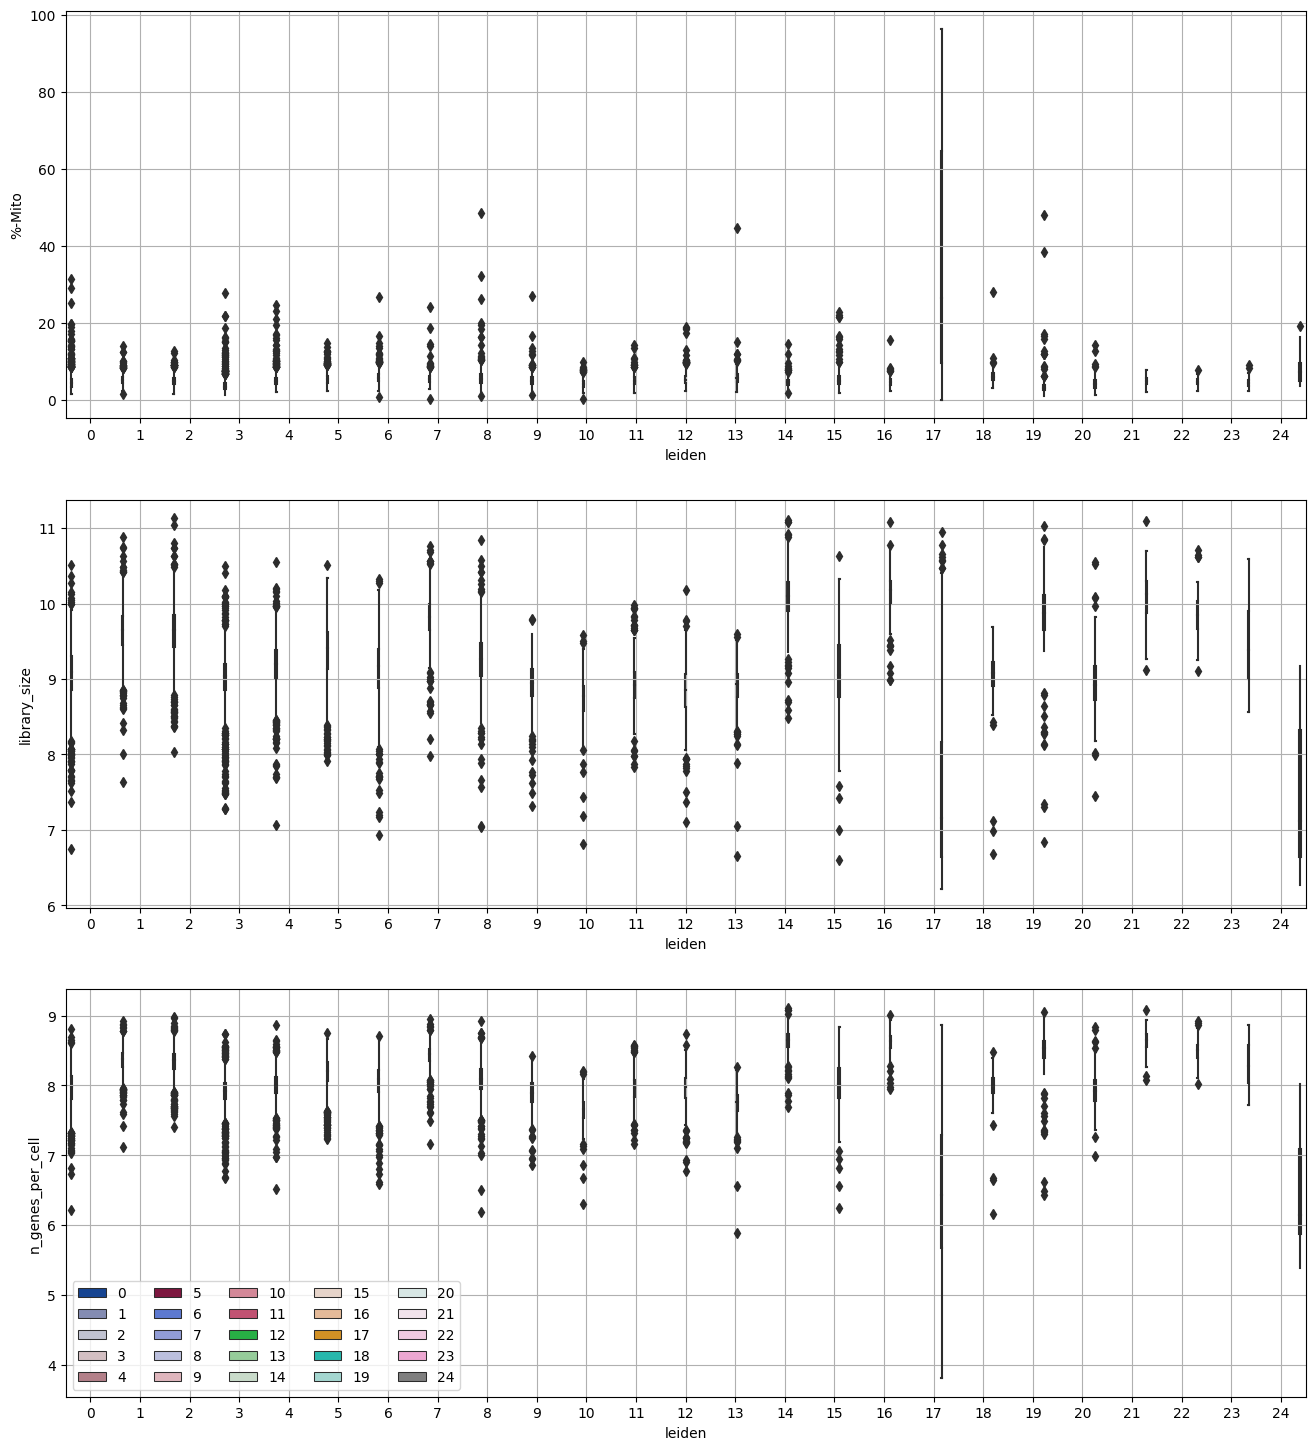

In [57]:
import seaborn as sns
fig = plt.figure(figsize = (8*2, 6*3))
ax = fig.add_subplot(3, 1, 1)
sns.boxplot(x = "leiden", y = "%-Mito", hue = 'leiden', data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')
ax.legend().set_visible(False)

ax = fig.add_subplot(3, 1, 2)
sns.boxplot(x = "leiden", y = "library_size", hue = 'leiden', data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')
ax.legend().set_visible(False)

ax = fig.add_subplot(3, 1, 3)
sns.boxplot(x = "leiden", y = "n_genes_per_cell", hue = 'leiden', data = df_temp, ax = ax, 
            palette = sc.pl.palettes.zeileis_28)
ax.grid('on')
ax.legend(loc="lower left", ncol = 5)

### Highlight clusters of interest

(-7.401524209976197, 18.82111325263977, -6.494140005111694, 18.89473376274109)

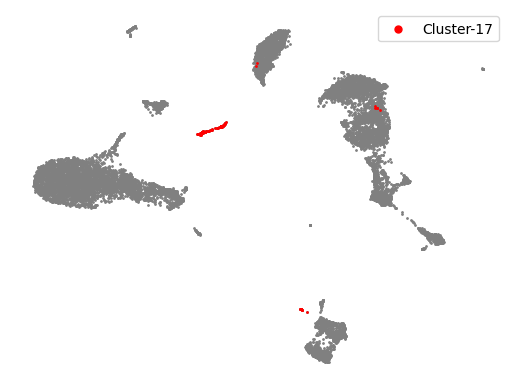

In [58]:
clusters_interest = ['17']
colors = ['red']
plt.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s = 1, color = 'gray')
for counter, item in enumerate(clusters_interest):
    cells_in_cluster = adata.obs['leiden_r1.5'] == item
    plt.scatter(adata.obsm['X_umap'][cells_in_cluster, 0], adata.obsm['X_umap'][cells_in_cluster, 1], s = 1, 
                color = colors[counter], label = 'Cluster-' + str(item))
    
plt.legend(markerscale = 5)
plt.axis('off')

### Remove the clusters

In [59]:
adata_clean = adata[~np.isin(adata.obs['leiden_r1.5'], clusters_interest), :]

In [60]:
adata_clean

View of AnnData object with n_obs × n_vars = 11828 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet', 'G2_M_checkpoint', 'leiden_r1.5', 'leiden_r0.5'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'leiden', 'leiden_r1.5_colors', 'leiden_r0.5_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

# Re-do pre-processing

In [61]:
# HVG
sc.pp.highly_variable_genes(adata_clean, layer = 'raw_data', n_top_genes = 4000, flavor = 'seurat_v3')

/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [62]:
# PCA
sc.tl.pca(adata_clean, n_comps=30, use_highly_variable=True)

In [63]:
# Nearest Neighbors
sc.pp.neighbors(adata_clean, n_neighbors=30, use_rep = 'X_pca', key_added= 'neighbors_30')

In [64]:
# UMAP
sc.tl.umap(adata_clean, neighbors_key = 'neighbors_30', min_dist=0.1)

In [65]:
# Clustering
sc.tl.leiden(adata_clean, resolution = 1, random_state=0, neighbors_key='neighbors_30')

In [66]:
adata_clean

AnnData object with n_obs × n_vars = 11828 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet', 'G2_M_checkpoint', 'leiden_r1.5', 'leiden_r0.5', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'leiden', 'leiden_r1.5_colors', 'leiden_r0.5_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

/Users/sara.jimenez/miniconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


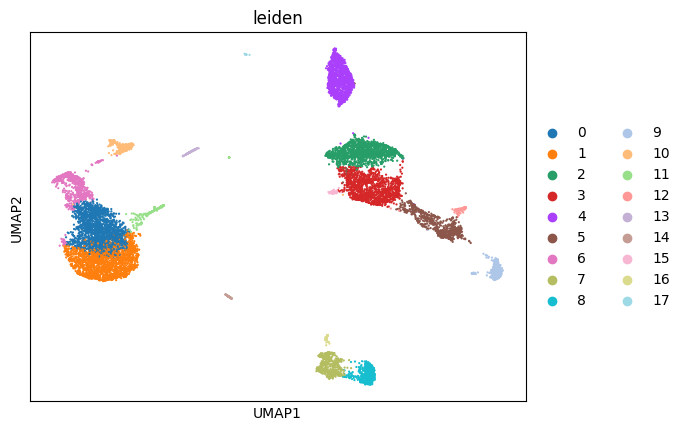

In [67]:
sc.pl.umap(adata_clean, color = 'leiden')

# Marker genes and cluster annotation 

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a *Welch t-test with overestimated variance* to be conservative. This is the default in `scanpy`. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

Annotation can be performed in an manual fashion or automated. 
* Manual annotation: based on the expression of marker genes, consultation with experts 
* Automated annotation: the development of large-scale atlases of different tissues allows to map the datasets to references. They are based on different principles, sometimes requiring pre-defined sets of markers, other times trained on pre-existing full scRNA-seq datasets.See also several reviews [Pasquini et al., 2021](10.1016/j.csbj.2021.01.015), [Abdelaal et al., 2019](https://doi.org/10.1186/s13059-019-1795-z) for a more elaborate discussion of automated annotation methods.

The resulting annotations can be of varying quality. It is therefore important to regard these methods as a starting point rather than an end-point of the annotation process.

Compute the differential expression profile for each cluster with `rank_genes_groups` and visualize the results.

In [68]:
adata_clean

AnnData object with n_obs × n_vars = 11828 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet', 'G2_M_checkpoint', 'leiden_r1.5', 'leiden_r0.5', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'leiden', 'leiden_r1.5_colors', 'leiden_r0.5_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [69]:
sc.pp.log1p(adata_clean)

In [70]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata_clean, groupby='leiden')

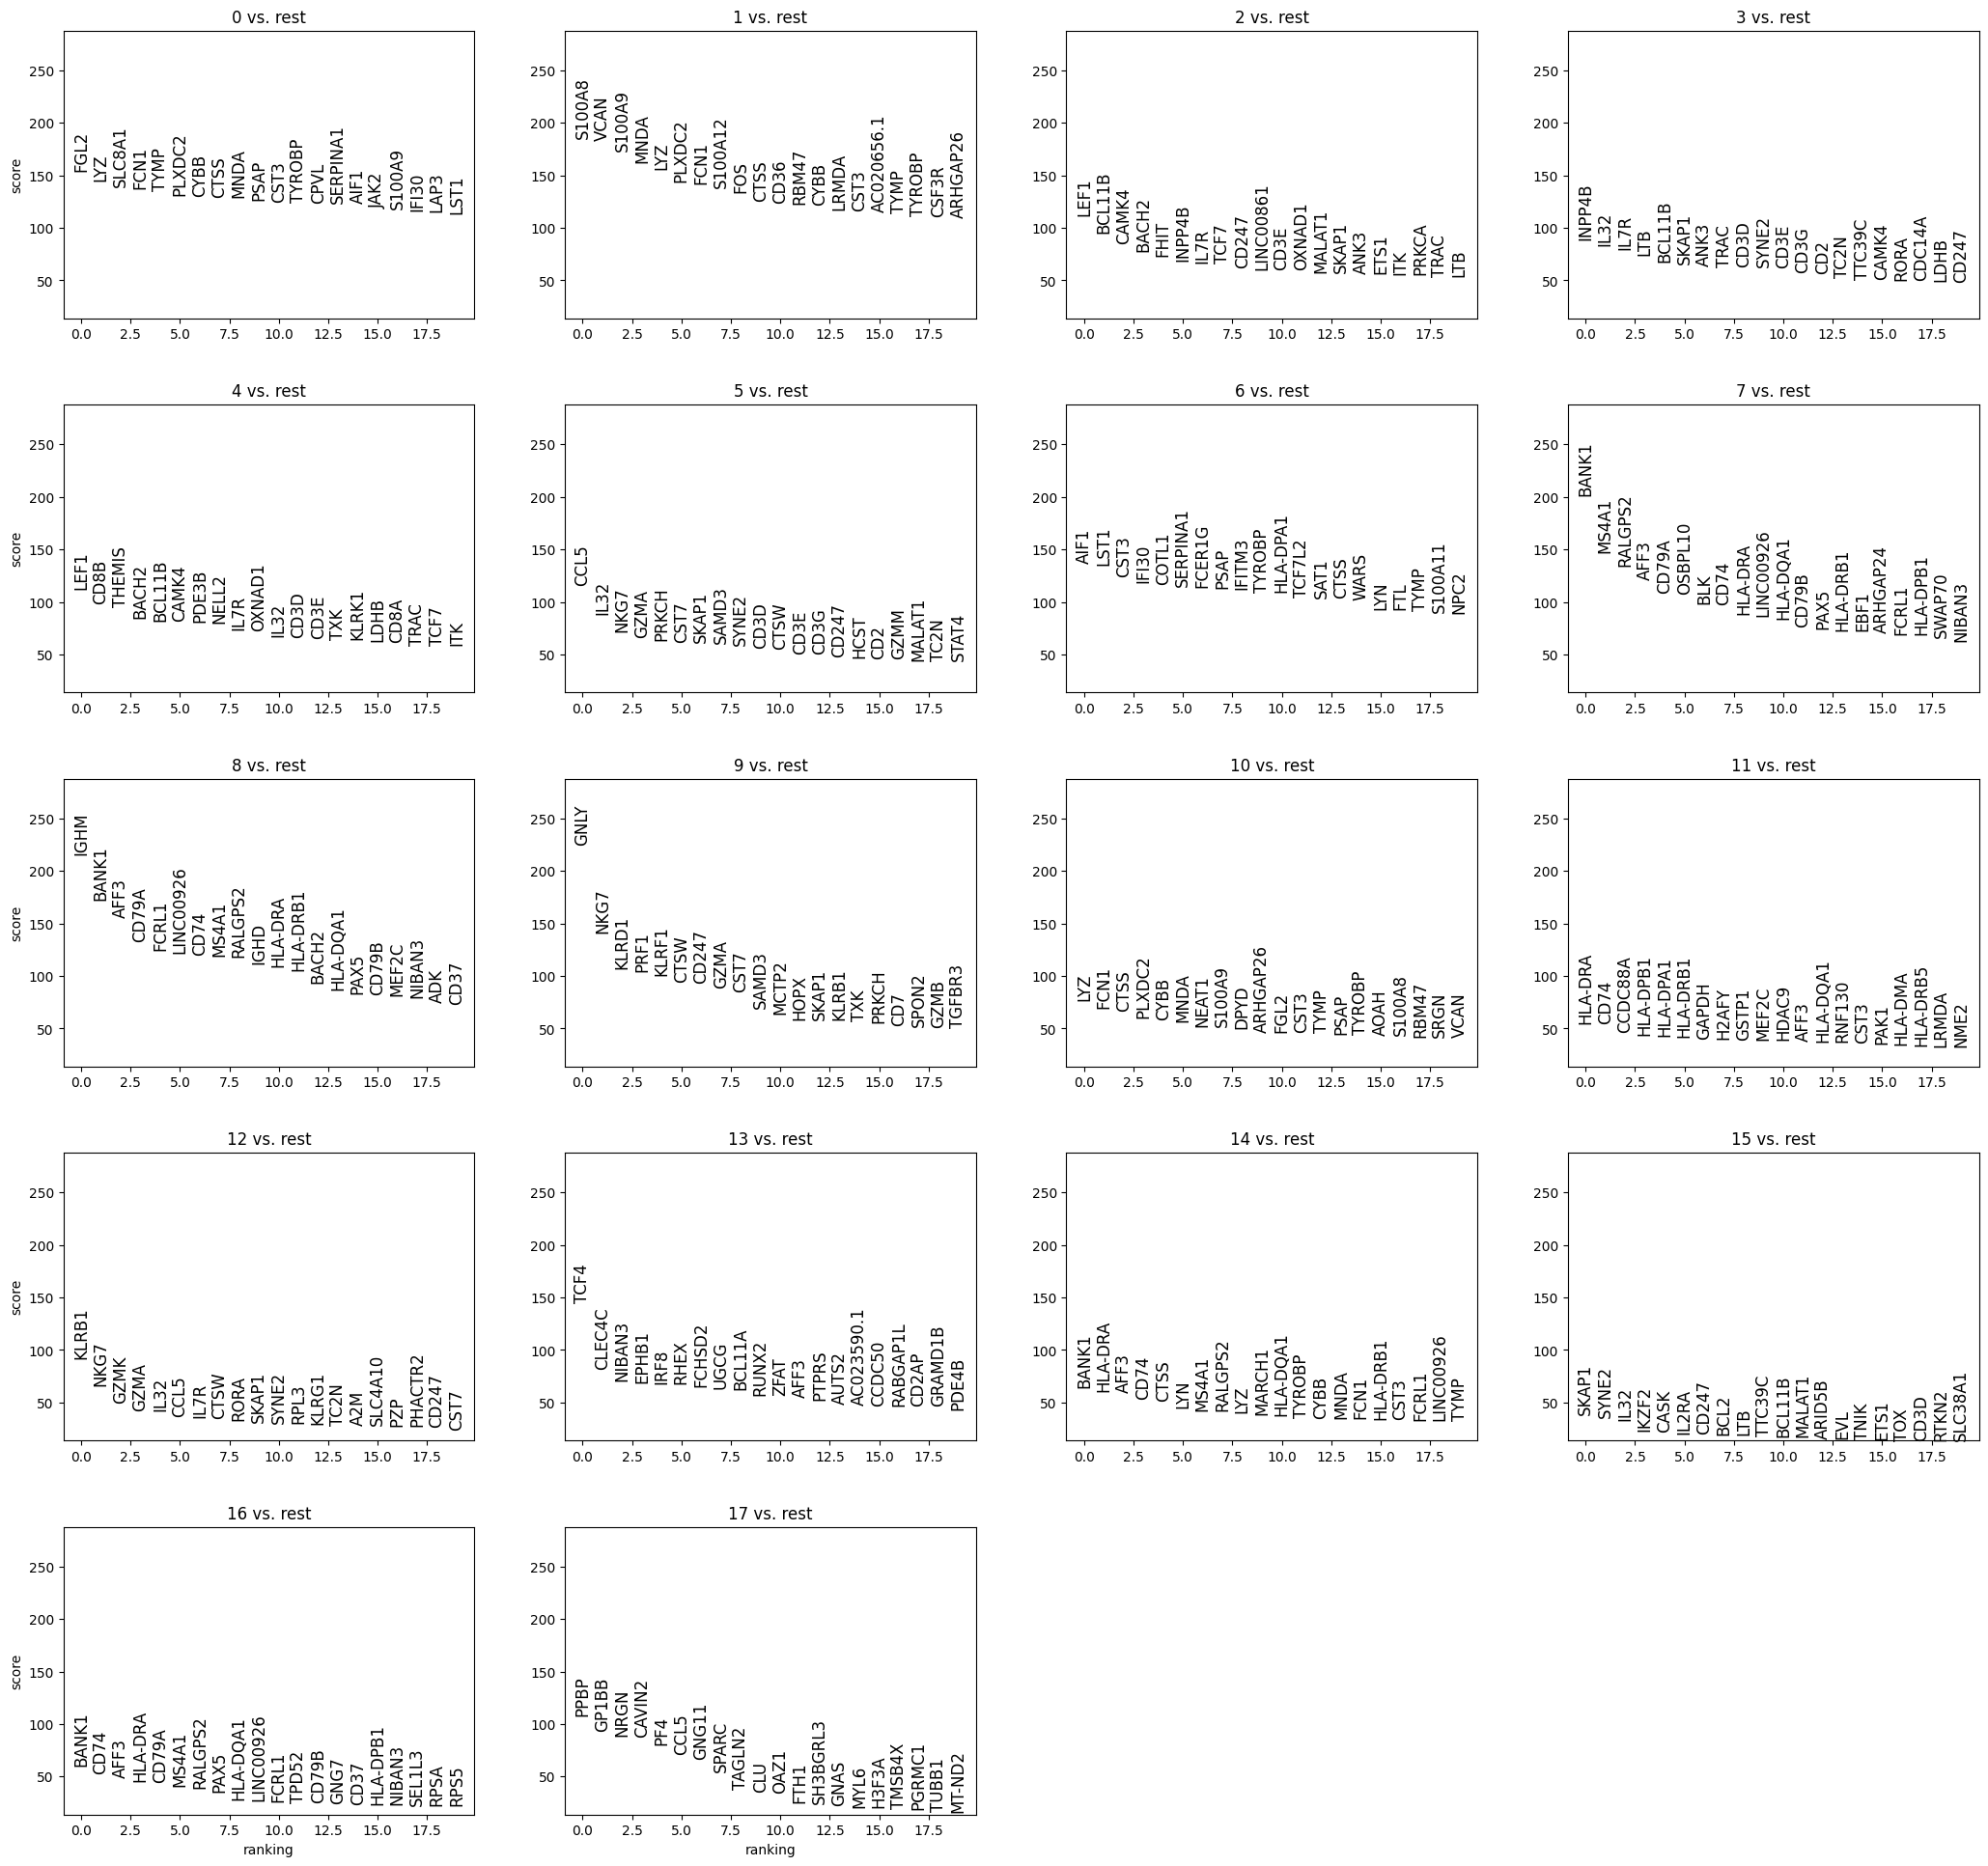

In [71]:
#Plot marker genes
sc.pl.rank_genes_groups(adata_clean, fontsize=12)

Here, we observe potentially characteristic gene expression patterns.

Furthermore, the score itself is not interpretable in terms of specificity and significance in the case of clustering, because the clusters were previously defined as a group of cells being different from the rest. Therefore, we compare a group that is a priori different to the rest and the resulting scores (or p-values) are inflated. Furthermore, the smaller a cluster is, the smaller is the observed score, unless a gene is very specific to the cluster. Typically, we may find marker genes in the gene lists of the `rank_genes_groups` test, but not all marker genes have a high expression level.

## Wilcoxon test

Seurat has a FindMarkers function (https://satijalab.org/seurat/reference/findmarkers) to compute differentially expressed genes, and by default it performs wilcoxon test for a gene in two different groups (typically on z-scored/scaled data). We will use the rank_genes_groups function in Scanpy to do the same.

On log normalized data

In [72]:
sc.tl.rank_genes_groups(adata_clean, groupby = 'leiden', groups='all', reference='rest', 
                        key_added='on_norm_log', method='wilcoxon')

Example output for Cluster 0:

In [73]:
df_wt = sc.get.rank_genes_groups_df(adata_clean, group = str(0), key = 'on_norm_log')

In [74]:
df_wt

names     scores  logfoldchanges  pvals  pvals_adj
0         FGL2  58.552078        2.490741    0.0        0.0
1         CPVL  56.514812        2.608812    0.0        0.0
2         LAP3  56.215076        2.082670    0.0        0.0
3      TNFSF10  55.252361        1.922799    0.0        0.0
4         JAK2  55.144421        1.915897    0.0        0.0
...        ...        ...             ...    ...        ...
17693    RPS29 -45.930557       -0.408103    0.0        0.0
17694    RPS19 -46.330307       -0.402818    0.0        0.0
17695     RPSA -46.638294       -0.685427    0.0        0.0
17696   MALAT1 -47.290688       -0.230423    0.0        0.0
17697     RPS3 -47.496426       -0.462448    0.0        0.0

[17698 rows x 5 columns]

Get the results for each cluster and save:

In [ ]:
for cluster in np.unique(adata_clean.obs['leiden']):
    df = sc.get.rank_genes_groups_df(adata_clean, group = str(cluster), key = 'on_norm_log')
    df.to_csv('path/to/save/wilcoxon_cluster_' + str(cluster) + '_vs_rest.csv')

## Other approaches:

If you wish to test other DEA approaches, please consider the following suggestings:

1) pseudobulk based edgeR analysis (https://www.sc-best-practices.org/conditions/differential_gene_expression.html)  

2) Memento: https://www.biorxiv.org/content/10.1101/2022.11.09.515836v1, https://github.com/yelabucsf/scrna-parameter-estimation

## Explore data using prior knowledge

When it comes to cluster annotation, we usually have to tap into prior knowledge of the cell type. Depending on the data set, this may involve extensive literature search.

In the case of PBMCs, we may refer to several studies and single-cell RNA-sequencing data analysis tutorials to extract marker gene sets. 

The following list is extracted from the Seurat tutorial on PBMCs.

|Marker Gene|Cell Type|
|---------|-------|
|IL7R|CD4 T cells|
|CD14, LYZ|CD14+ Monocytes|
|MS4A1|B cells|
|CD8A|CD8 T cells|
|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|GNLY, NKG7|NK cells|
|FCER1A, CST3|Dendritic Cells|
|PPBP|Megakaryocytes|

In [75]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

**Tasks:** Annotate the clusters. 
Check briefly, if all marker genes are present in the dataset and visualise the marker genes in a UMAP (or another visualisation of your choice).
You can use auxiliary plots like `matrixplot`, `dotplot`, `heatmap` or `violin` plots or coloring an embedding (e.g. UMAP) by the marker genes.

Let us check if the marker genes are expressed in our dataset.

In [76]:
np.in1d(marker_genes, adata_clean.var_names)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [159]:
#plots

In [ ]:
sc.pl.dotplot(adata=, 
              var_names =,
              groupby=, 
              use_raw=False)

In [ ]:
sc.pl.heatmap(adata=, 
              var_names=, 
              figsize=(5,10),
              groupby=, 
              use_raw=False, vmin=0)

In [ ]:
sc.pl.matrixplot(adata=, 
                 var_names=,
                 groupby=, 
                 use_raw=False, vmin=0)

In [ ]:
sc.pl.stacked_violin(adata = ,
                     var_names = , 
                     groupby=, 
                     use_raw=False)

Annotate clusters and create a new covariate.


|Cluster ID|Marker Gene|Cell Type|
|---------|-------|-------|
||IL7R|CD4 T cells|
||CD14, LYZ|CD14+ Monocytes|
||MS4A1|B cells|
||CD8A|CD8 T cells|
||FCGR3A, MS4A7|FCGR3A+ Monocytes|
||GNLY, NKG7|NK cells|
||FCER1A, CST3|Dendritic Cells|
||PPBP|Megakaryocytes|

Use the `pandas` data frame functionality to rename your clusters and visualize your annotation.

In [ ]:
adata_clean.obs['annotated'] = adata_clean.obs['louvain_r1.5'].cat.add_categories(['CD4 T cells', 
                        'CD14+ Monocytes', 'B cells', 'CD8 T cells', 
                        'FCGR3A+ Monocytes', 'NK cells', 'Dendritic cells', 'Megakaryocytes'])

adata_clean.obs['annotated'][np.in1d(adata_clean.obs['annotated'], [ #add cluster name here (as string)    
                                                            ])] = 'CD4 T cells'
adata_clean.obs['annotated'][np.in1d(adata_clean.obs['annotated'], [])] = 'CD14+ Monocytes'
adata_clean.obs['annotated'][np.in1d(adata_clean.obs['annotated'], [])] = 'B cells'
adata_clean.obs['annotated'][np.in1d(adata_clean.obs['annotated'], [])] = 'CD8 T cells'
adata_clean.obs['annotated'][np.in1d(adata_clean.obs['annotated'], [])] = 'FCGR3A+ Monocytes'
adata_clean.obs['annotated'][np.in1d(adata_clean.obs['annotated'], [])] = 'NK cells'
adata_clean.obs['annotated'][np.in1d(adata_clean.obs['annotated'], [])] = 'Dendritic cells'
adata_clean.obs['annotated'][np.in1d(adata_clean.obs['annotated'], [])] = 'Megakaryocytes'

#remove unused categories from annotation
adata_clean.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()

In [ ]:
# check how many cells per cell type annotated
adata_clean.obs['annotated'].value_counts()

**Task:** Visualise your annotation on a UMAP as well as in a `matrixplot`, `dotplot`, `heatmap` or `violin` plots.

In [ ]:
sc.pl.umap(adata = , color='annotated', legend_loc='on data', title='', frameon=False)
sc.pl.umap(adata = , color='annotated',  title='', frameon=True)

In [ ]:
sc.pl.dotplot(adata=, 
              var_names =,
              groupby=, 
              use_raw=False)

In [ ]:
sc.pl.heatmap(adata=, 
              var_names=, 
              figsize=(5,10),
              groupby=, 
              use_raw=False, vmin=0)

In [ ]:
sc.pl.matrixplot(adata = , 
                 var_names = , 
                 groupby= , 
                 use_raw=False, vmin=0)

In [ ]:
sc.pl.stacked_violin(adata=   , 
                     var_names=   , 
                     groupby=    , 
                     use_raw=False)

# Save results for future

In [77]:
adata_clean

AnnData object with n_obs × n_vars = 11828 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet', 'G2_M_checkpoint', 'leiden_r1.5', 'leiden_r0.5', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors_30', 'umap', 'leiden', 'leiden_r1.5_colors', 'leiden_r0.5_colors', 'leiden_colors', 'rank_genes_groups', 'on_norm_log'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

In [78]:
adata_clean = adata_clean.write_h5ad(input_path + 'processed/annotated_data.h5ad')